# Agenda


**Objective**  
1) Predict RUL  
2) Categorize maintenance required engines < 42 cycles and check accuracy

**Flow**
1) Data extraction, EDA & Feature selection/engineering
2) Predictive model
3) Conclusion (Recommandation)

# 1. Data extraction, EDA & Feature selection/engineering

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [4]:
# Dict for column headers; refer to the paper
df_columns = {
    0: "engine",
    1: "cycle_time",
    2: "operational_set_1",
    3: "operational_set_2",
    4: "operational_set_3",
    5: "T2",
    6: "T24",
    7: "T30",
    8: "T50",
    9: "P2",
    10: "P15",
    11: "P30",
    12: "Nf",
    13: "Nc",
    14: "epr",
    15: "Ps30",
    16: "phi",
    17: "NRf",
    18: "NRc",
    19: "BPR",
    20: "farB",
    21: "htBleed",
    22: "Nf_dmd",
    23: "PCNfR_dmd",
    24: "W31",
    25: "W32",
}

RUL_columns = {
    0: "RUL"
}

In [5]:
"""Load data from files"""
import glob as gl
import pandas as pd
import pathlib as pth


def load_file(path: str, load_all: bool = False, filter: str = None, sep: str = None, header: int = 0) -> pd.DataFrame:
    if pth.Path(path).is_file():
        if path.endswith(".csv"):
            dfs = pd.read_csv(path, header=header)
        elif path.endswith(".txt"):
            dfs = pd.read_csv(path, sep=sep, header=header)
        elif path.endswith(".xlsx"):
            dfs = pd.read_excel(path, header=header)
    elif pth.Path(path).is_dir() and load_all:
        df_list = []
        files = gl.glob(f"{path}/*")
        if filter:
            files = [i for i in files if filter in i]
        print("files to be loaded:", files)
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(file, low_memory=False, header=header)
                df_list.append(df)
            elif file.endswith(".txt"):
                df = pd.read_csv(file, sep=sep, header=header)
                df_list.append(df)
            elif file.endswith(".xlsx"):
                df = pd.read_excel(file, header=header)
                df_list.append(df)                
        dfs = pd.concat(df_list)
        dfs.reset_index(drop=True, inplace=True)
    elif pth.Path(path).is_dir() and not load_all:
        raise ValueError("load_all should be True")
    else:
        raise ValueError("error")

    return dfs

In [6]:
# We will use only FD001 case
train_df = load_file(path="data/train_FD001.txt", load_all=False, sep="\s+", header=None)
test_df = load_file(path="data/test_FD001.txt", load_all=False, sep="\s+", header=None)
RUL_df = load_file(path="data/RUL_FD001.txt", load_all=False, sep="\s+", header=None)

In [7]:
# Rename columns
train_df = train_df.rename(columns=df_columns)
test_df = test_df.rename(columns=df_columns)
RUL_df = RUL_df.rename(columns=RUL_columns)
RUL_df["engine"] = RUL_df.index + 1

In [8]:
# Display first 5 rows of each df
print(train_df.head())
print(test_df.head())
print(RUL_df.head())

   engine  cycle_time  operational_set_1  operational_set_2  \
0       1           1            -0.0007            -0.0004   
1       1           2             0.0019            -0.0003   
2       1           3            -0.0043             0.0003   
3       1           4             0.0007             0.0000   
4       1           5            -0.0019            -0.0002   

   operational_set_3      T2     T24      T30      T50     P2  ...     phi  \
0              100.0  518.67  641.82  1589.70  1400.60  14.62  ...  521.66   
1              100.0  518.67  642.15  1591.82  1403.14  14.62  ...  522.28   
2              100.0  518.67  642.35  1587.99  1404.20  14.62  ...  522.42   
3              100.0  518.67  642.35  1582.79  1401.87  14.62  ...  522.86   
4              100.0  518.67  642.37  1582.85  1406.22  14.62  ...  522.19   

       NRf      NRc     BPR  farB  htBleed  Nf_dmd  PCNfR_dmd    W31      W32  
0  2388.02  8138.62  8.4195  0.03      392    2388      100.0  39.06  23

## RUL mapping into training data

In [9]:
# calculate maximum cycle_time per engine
max_time_cycles = train_df.groupby("engine")["cycle_time"].max()
# To check result
# for idx, row in max_time_cycles.reset_index().iterrows():
#     print("Engine:", row["engine"], "Failure_time:", row["cycle_time"])
# merge into maximum cycle time into train df
merged = train_df.merge(max_time_cycles.to_frame(name="max_time_cycle"), left_on="engine", right_index=True)
# calculate RUL = maximum cycle time - each cycle time
merged["RUL"] = merged["max_time_cycle"] - merged["cycle_time"]
# drop maximum cycle time (not used)
merged = merged.drop("max_time_cycle", axis=1)
# update train df with RUL 
train_df = merged

In [10]:
train_df.head()

engine  cycle_time  operational_set_1  operational_set_2  \
0       1           1            -0.0007            -0.0004   
1       1           2             0.0019            -0.0003   
2       1           3            -0.0043             0.0003   
3       1           4             0.0007             0.0000   
4       1           5            -0.0019            -0.0002   

   operational_set_3      T2     T24      T30      T50     P2  ...      NRf  \
0              100.0  518.67  641.82  1589.70  1400.60  14.62  ...  2388.02   
1              100.0  518.67  642.15  1591.82  1403.14  14.62  ...  2388.07   
2              100.0  518.67  642.35  1587.99  1404.20  14.62  ...  2388.03   
3              100.0  518.67  642.35  1582.79  1401.87  14.62  ...  2388.08   
4              100.0  518.67  642.37  1582.85  1406.22  14.62  ...  2388.04   

       NRc     BPR  farB  htBleed  Nf_dmd  PCNfR_dmd    W31      W32  RUL  
0  8138.62  8.4195  0.03      392    2388      100.0  39.06  23.4190  191  
1  8131.49  8.4318  0.03      392    2388      100.0  39.00  23.4236  190  
2  8133.23  8.4178  0.03      390    2388      100.0  38.95  23.3442  189  
3  8133.83  8.3682  0.03      392    2388      100.0  38.88  23.3739  188  
4  8133.80  8.4294  0.03      393    2388      100.0  38.90  23.4044  187  

[5 rows x 27 columns]

## EDA

### Target value

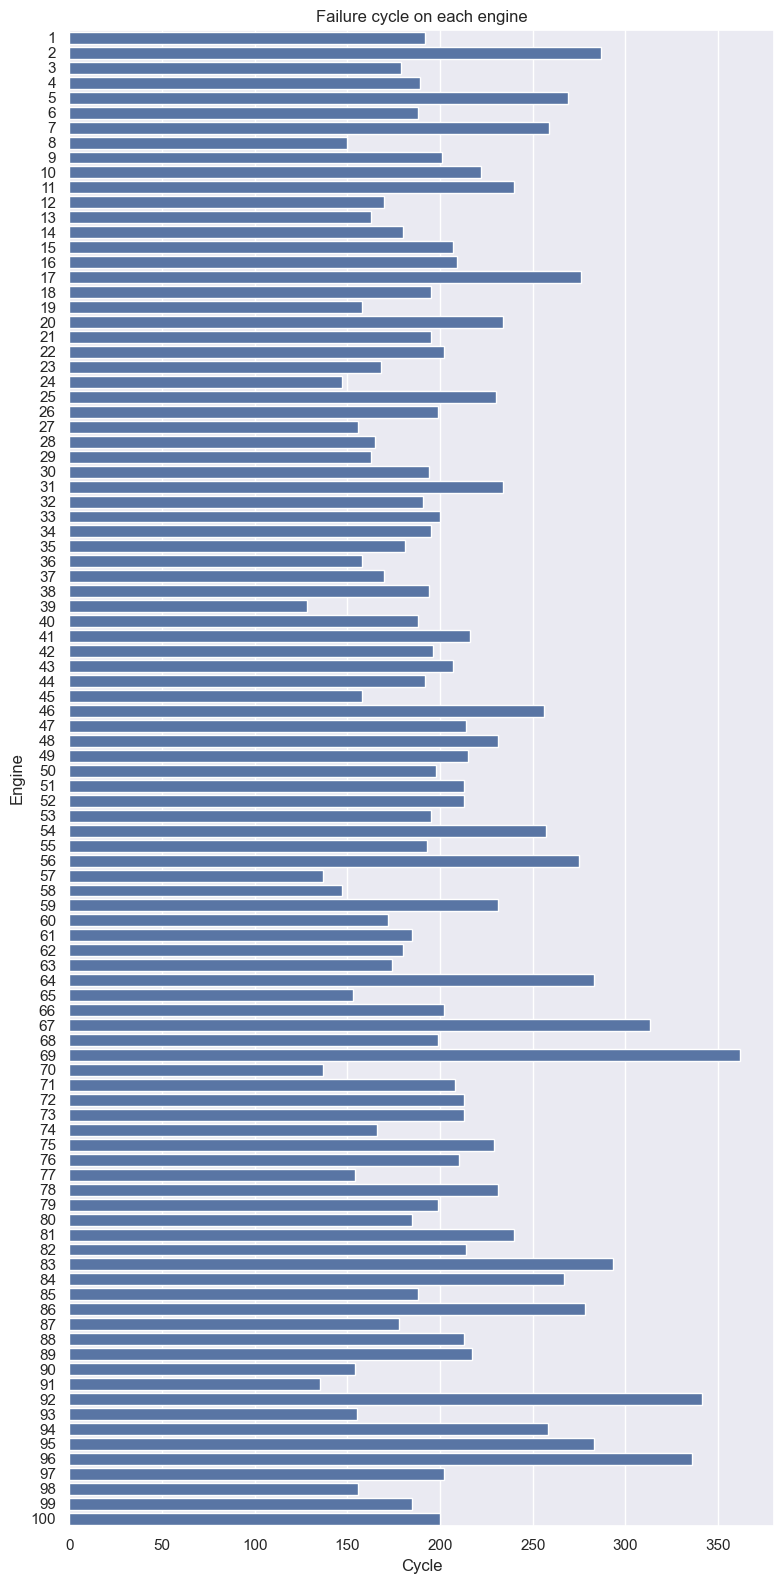

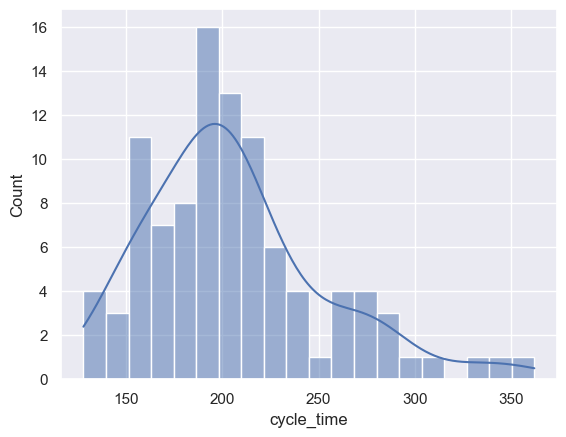

In [11]:
# plot maximum cycle_time per engine
failure_time=max_time_cycles.reset_index()

plt.figure(figsize=(8,16))
sns.set_theme()
sns.barplot(y=failure_time["engine"], x=failure_time["cycle_time"], orient="h")
plt.title("Failure cycle on each engine")
plt.ylabel("Engine")
plt.xlabel("Cycle")
plt.tight_layout()
plt.show()

# distribution of maximum cycle_time
plt.figure()
sns.histplot(failure_time["cycle_time"], kde=True, bins=20)
plt.show()

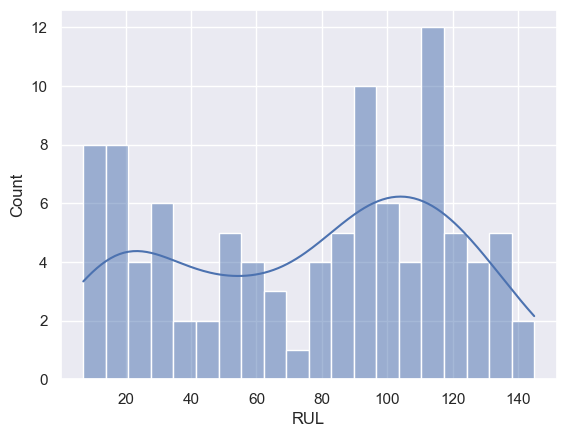

(13096, 26)


In [12]:
# distribution of RUL (answer)
plt.figure()
sns.histplot(RUL_df["RUL"], kde=True, bins=20)
plt.show()

print(test_df.shape)

### General EDA

In [ ]:
"""EDA modules"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class EDA:
    """Class for General EDA.

    variables
    ----------
    df: pd.DataFrame
    target_col: str
        Target column on dataframe (only one column)
        - This column would be defined if you want to explicitly compare to other features
    ----------
    """
    def __init__(self, df: pd.DataFrame, target_col: str = None) -> None:
        """Initialize variables and define columns."""
        self._df = df
        self._tgt_col = target_col
        self._num_cols = df.select_dtypes(include="number").columns
        self._cat_cols = df.select_dtypes(include=["object", "category"]).columns
        print("Numerical columns")
        print(self._num_cols)
        print("--------")
        print("Categorical columns")
        print(self._cat_cols)
        print("--------")
        print("Target column")

    def describe_df(self) -> None:
        """Describe dataframe; info, nunique, null ratio & describe."""
        print("Overall")
        print(self._df.info())
        print("--------")
        print("Unique value count")
        print(self._df.nunique())
        print("--------")
        print("Null value rate")
        print(self._df.isnull().sum()/len(self._df)*100)
        print("--------")
        print("Describe numerical columns")
        print(self._df.describe())
        print("--------")
        if len(self._cat_cols) > 0:
            print("Describe categorical columns")
            print(self._df.describe(include="object"))
            print("--------")

    def dist_plot(self) -> None:
        """Distribution plots: histgram, boxplot & violin plot.

        If target column defined, then plots will be generated except the target column.
        """
        if self._tgt_col:
            for col in [x for x in self._num_cols if x != self._tgt_col]:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent", hue=self._tgt_col)
                sns.boxplot(self._df, x=col, hue=self._tgt_col, ax=ax[1])
                sns.violinplot(self._df, x=col, hue=self._tgt_col, ax=ax[2], alpha=0.3)
                plt.legend()
                plt.show()

        else:
            for col in self._num_cols:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent")
                sns.boxplot(self._df, x=col, ax=ax[1])
                sns.violinplot(self._df, x=col, ax=ax[2], alpha=0.3)
                plt.show()

    def counter_plot(self) -> None:
        """Counter plots.

        If target column defined, then plots will be generated except the target column.
        """
        for col in self._cat_cols:
            f, ax = plt.subplots(1,1,figsize=(12,4))
            sns.countplot(data=self._df, x=col, ax=ax)
            x_labels_1 = [label.get_text() for label in ax.get_xticklabels()]
            ax.set_xticklabels(x_labels_1, rotation=45)
            plt.show()


    def pair_plot(self) -> None:
        """Pair plot"""
        if self._tgt_col:
            _ = sns.pairplot(self._df, hue=self._tgt_col)
        else:
            _ = sns.pairplot(self._df)

    def pie_plot_target(self) -> None:
        """Pie plot for target column."""
        tgt_counts = self._df[self._tgt_col].value_counts()

        plt.figure()
        plt.pie(tgt_counts, labels=tgt_counts.index, autopct='%1.1f%%', colors=["#5B91B5", "#E47336"])
        plt.title(f"Distribution of {self._tgt_col}")
        plt.show()

    def dist_plot_target(self) -> None:
        """Distribution plot for target column."""
        plt.figure()
        sns.histplot(self._df[self._tgt_col], kde=True)
        plt.show()

    def corr_plot(self) -> None:
        """Calculate Pearson correlation among numerical columns and plot it."""
        df_corr = self._df.corr(numeric_only=True)
        mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
        df_corr_fil = df_corr.where(mask)

        plt.figure(figsize=(16,16))
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01)
        plt.show()

        plt.figure(figsize = (16,16))
        mask = df_corr_fil.where(abs(df_corr_fil) > 0.9).isna()
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01, mask=mask)
        plt.show()


    def plot_all(self) -> None:
        """Execute all functions."""
        self.describe_df()
        # If Binary value on the target column, then create a pie plot; otherwise histogram.
        if self._tgt_col:
            if len(self._df[self._tgt_col].unique()) > 2:
                self.dist_plot_target()
            else:
                self.pie_plot_target()
        self.dist_plot()
        self.counter_plot()
        self.corr_plot()

In [15]:
eda = EDA(train_df)

Numerical columns
Index(['engine', 'cycle_time', 'operational_set_1', 'operational_set_2',
       'operational_set_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30',
       'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB',
       'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32', 'RUL'],
      dtype='object')
--------
Categorical columns
Index([], dtype='object')
--------
Target column


Overall
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   engine             20631 non-null  int64  
 1   cycle_time         20631 non-null  int64  
 2   operational_set_1  20631 non-null  float64
 3   operational_set_2  20631 non-null  float64
 4   operational_set_3  20631 non-null  float64
 5   T2                 20631 non-null  float64
 6   T24                20631 non-null  float64
 7   T30                20631 non-null  float64
 8   T50                20631 non-null  float64
 9   P2                 20631 non-null  float64
 10  P15                20631 non-null  float64
 11  P30                20631 non-null  float64
 12  Nf                 20631 non-null  float64
 13  Nc                 20631 non-null  float64
 14  epr                20631 non-null  float64
 15  Ps30               20631 non-null  float64
 16  phi           

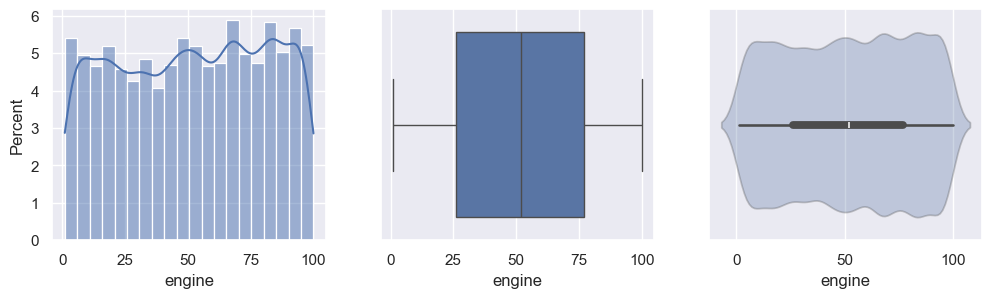

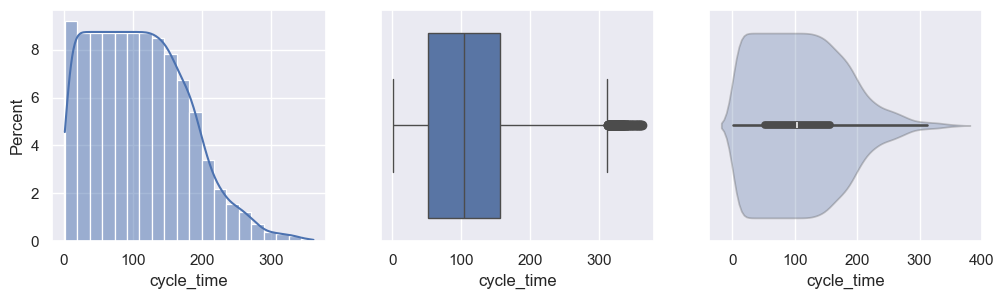

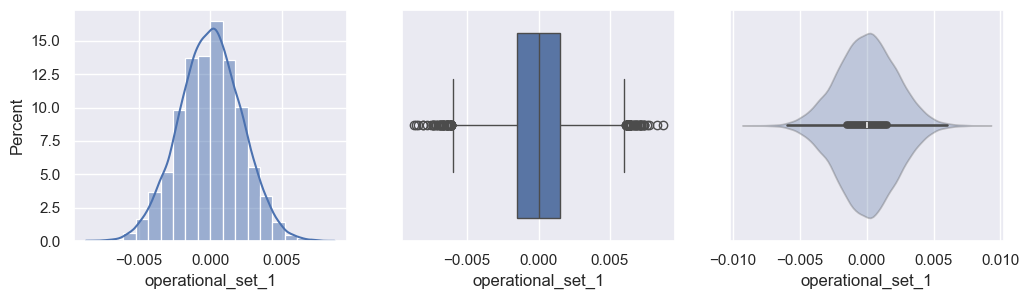

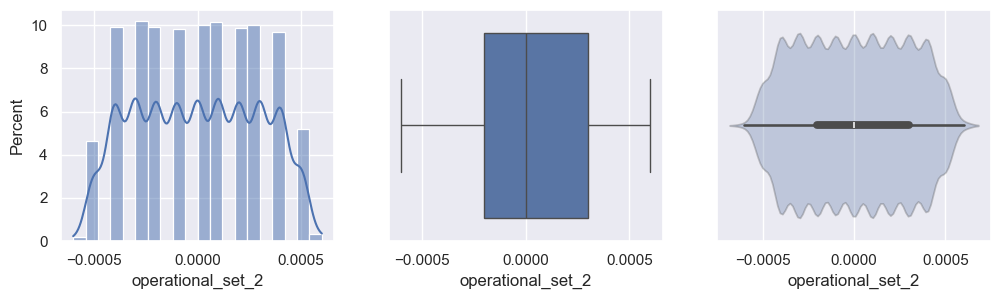

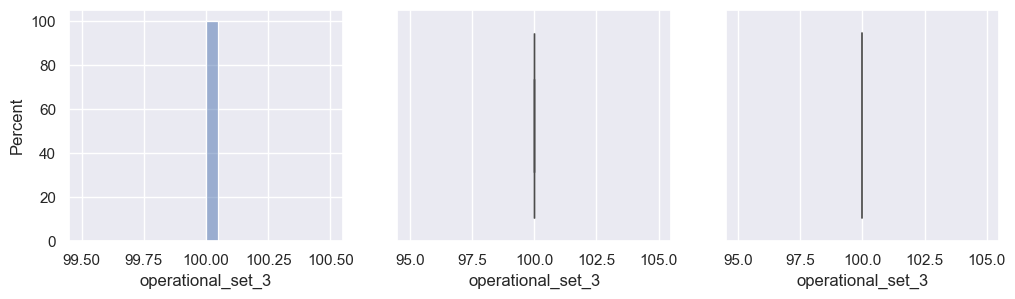

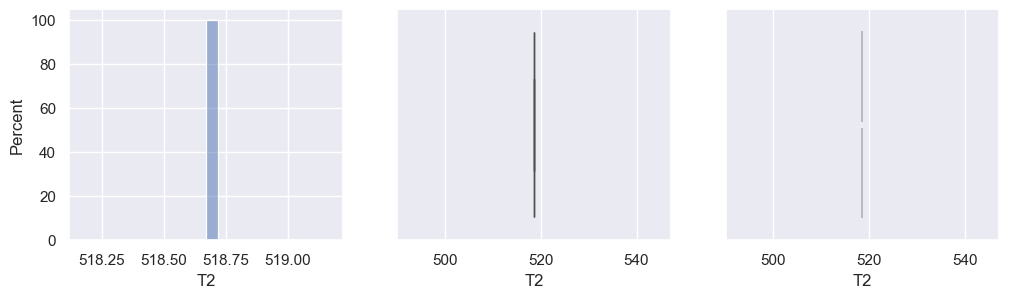

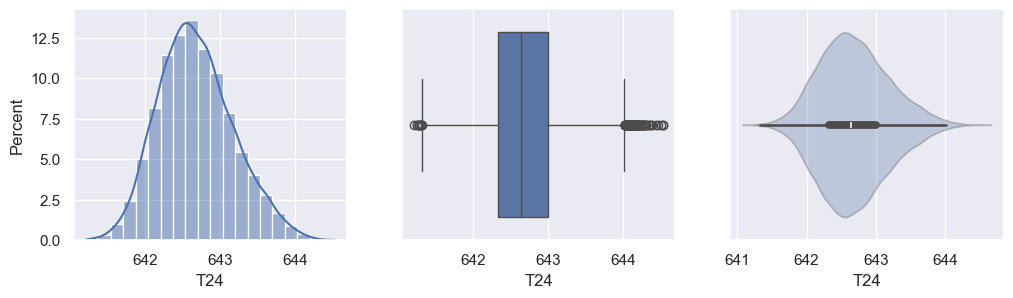

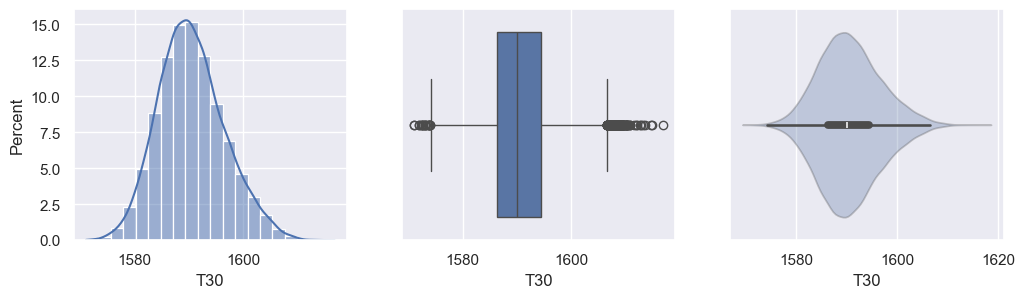

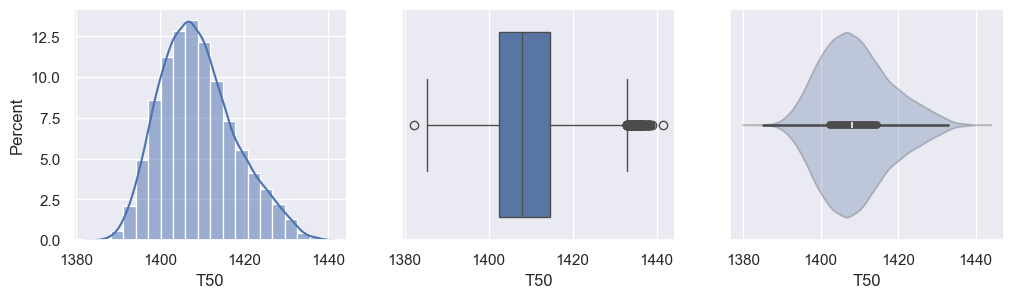

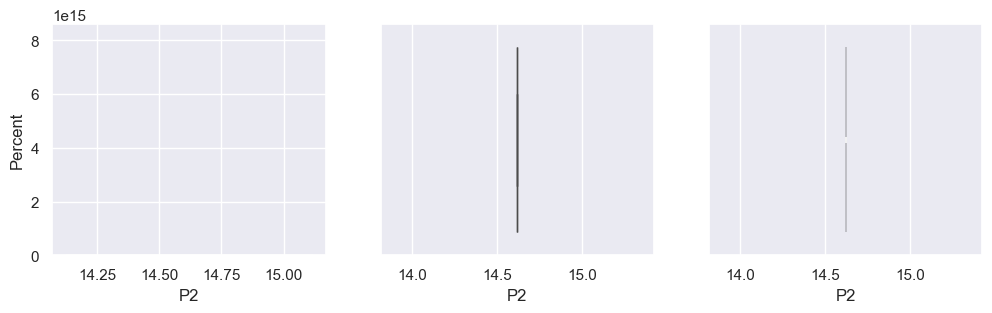

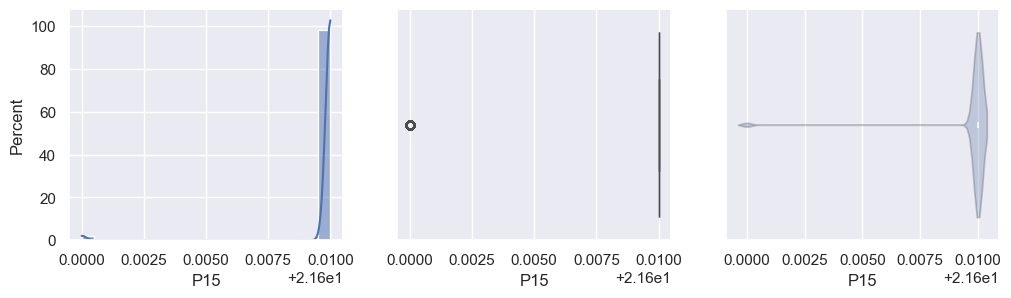

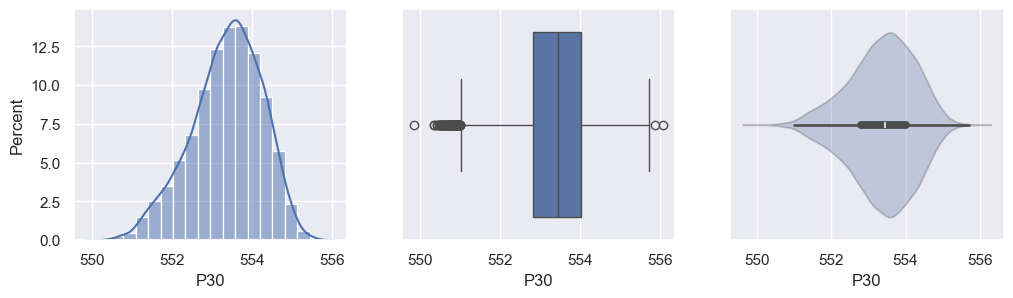

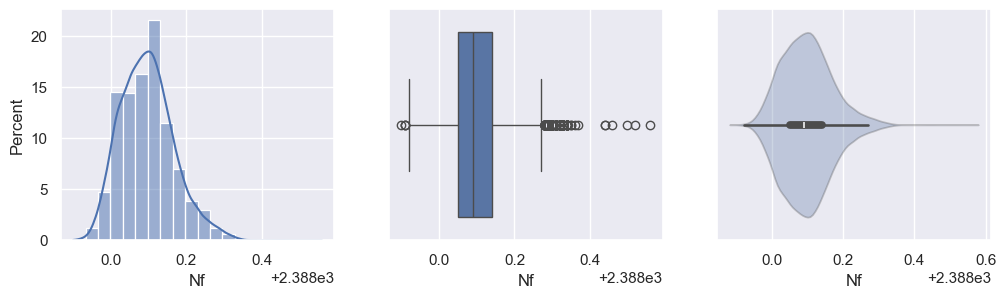

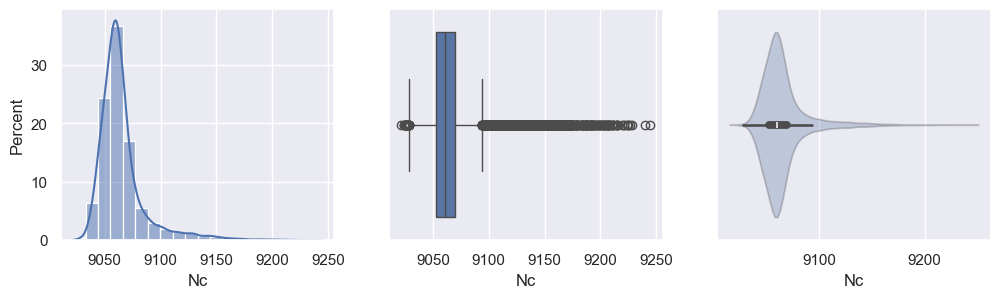

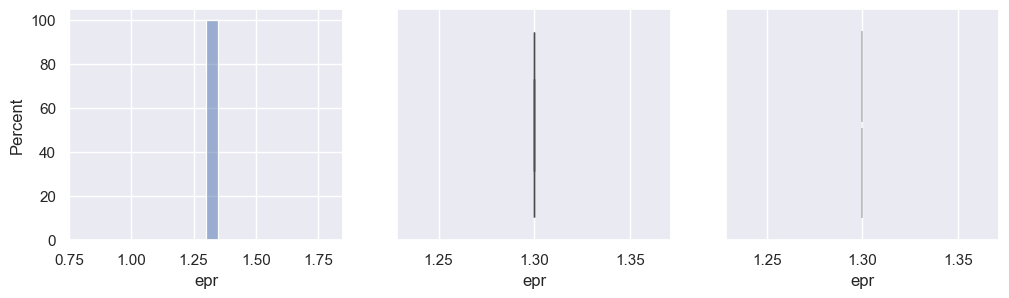

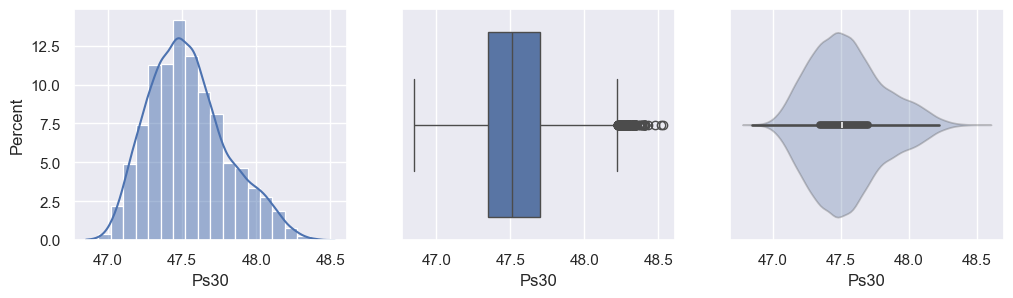

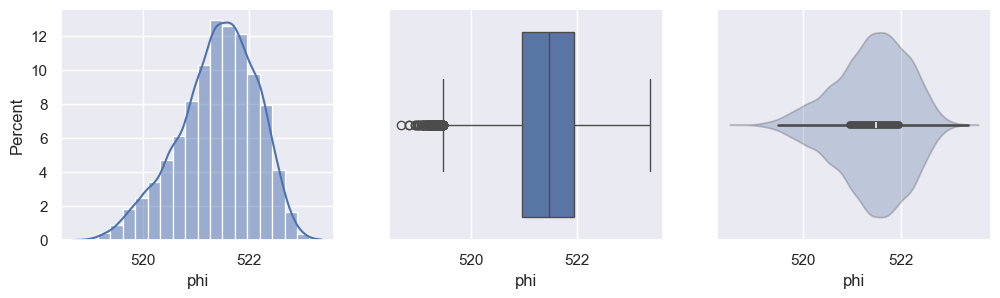

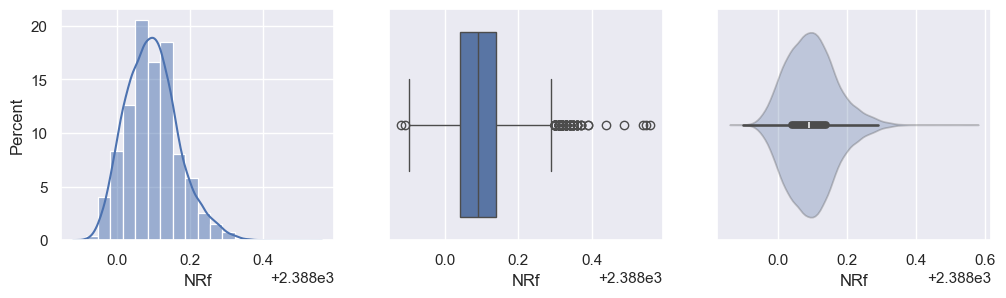

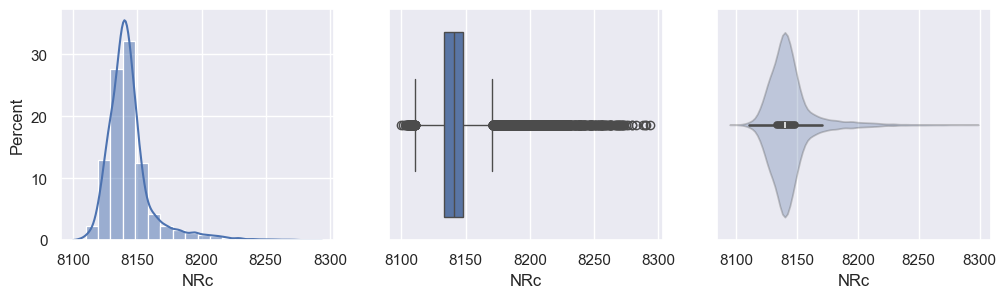

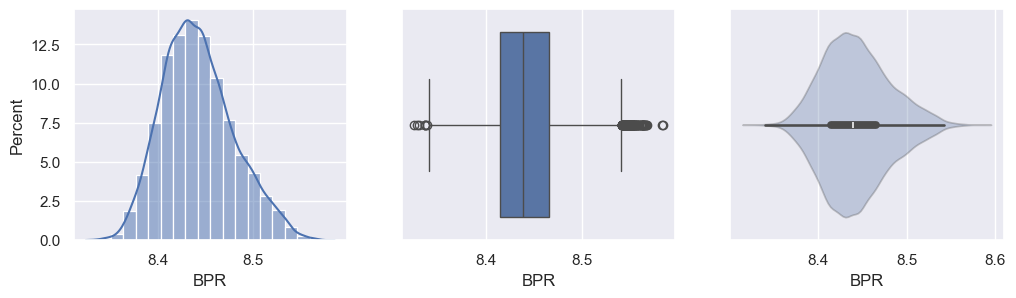

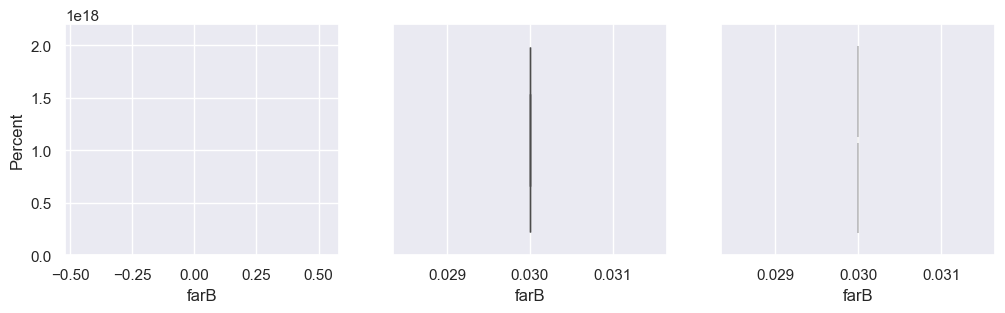

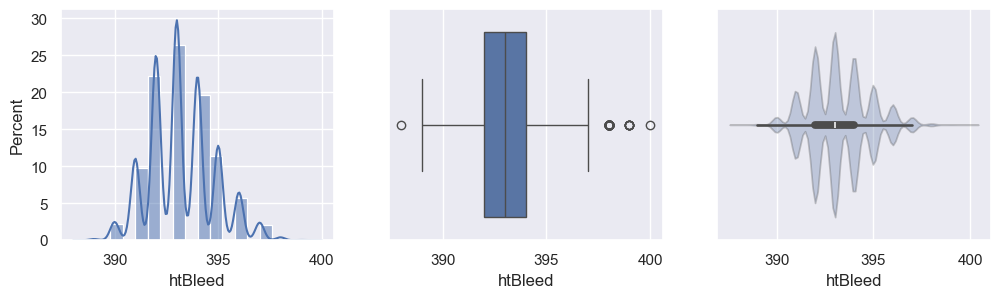

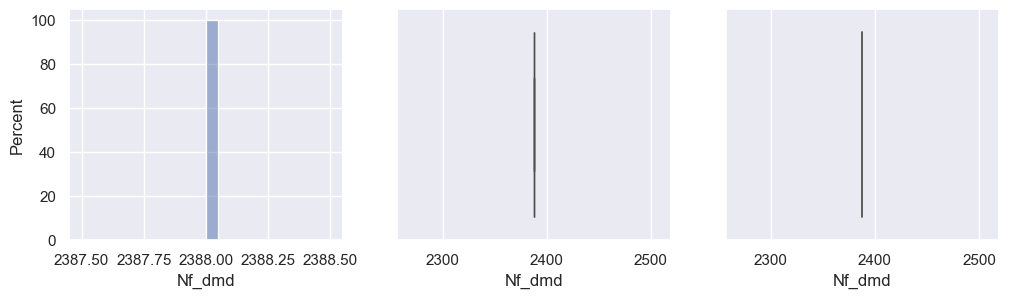

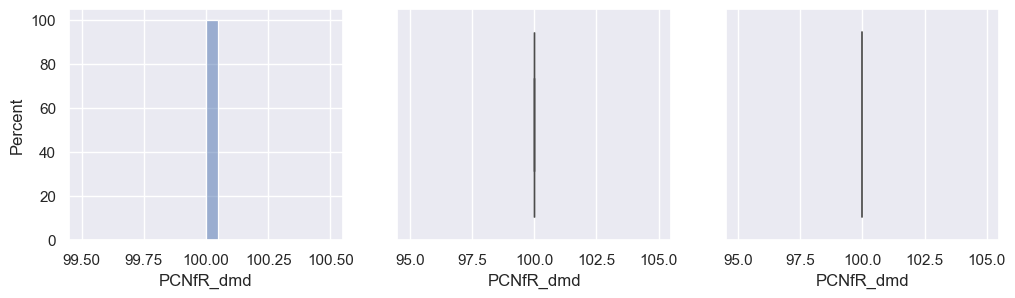

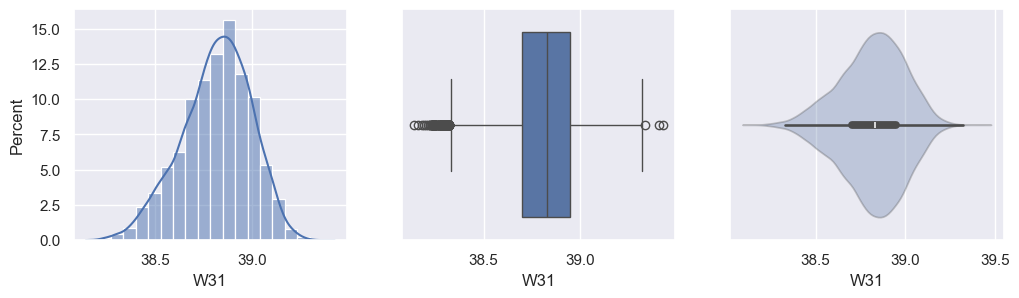

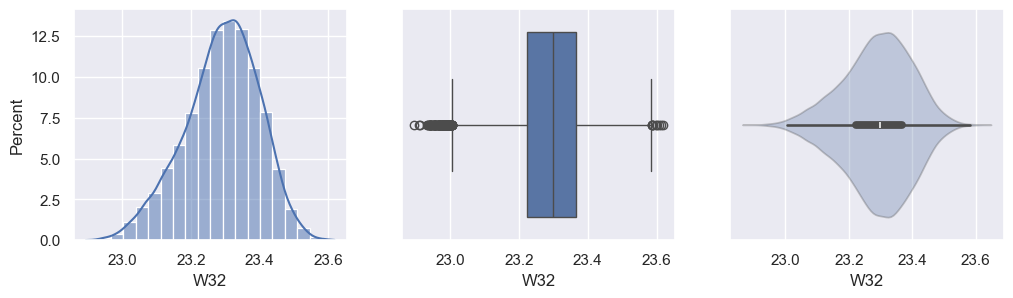

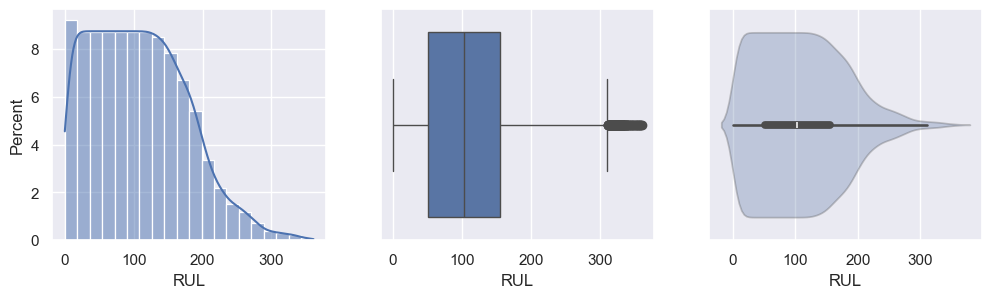

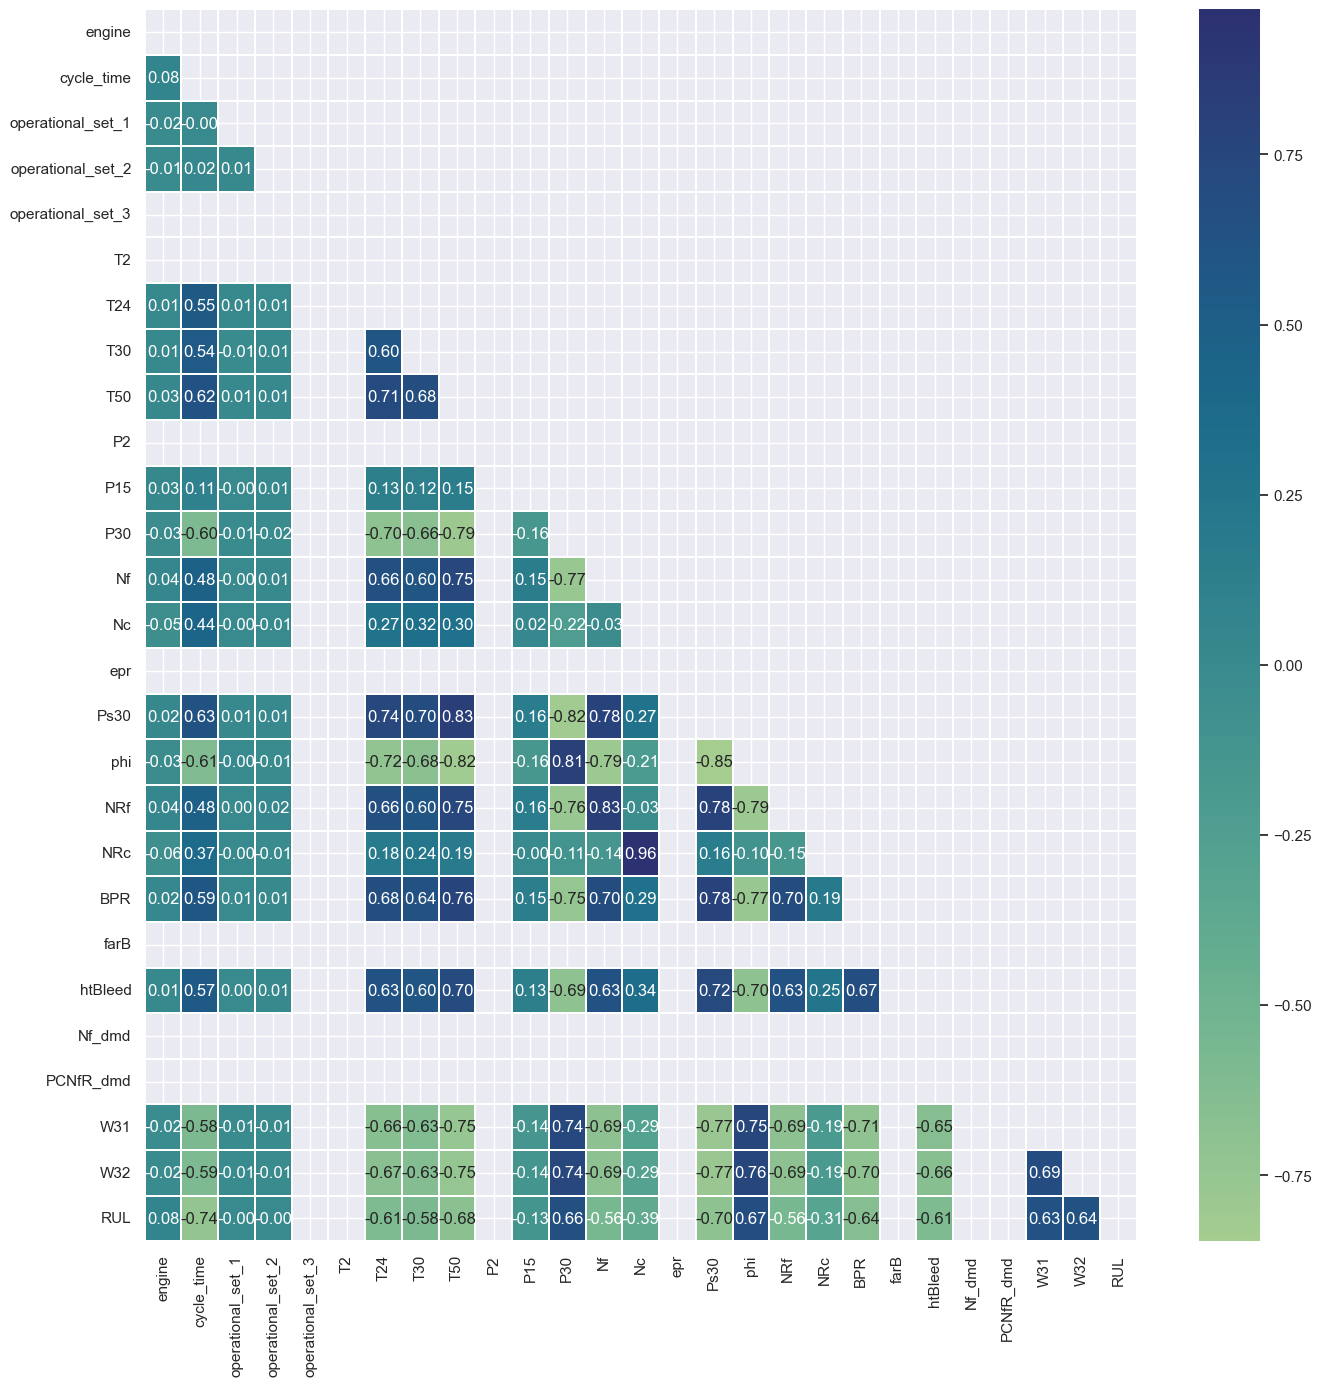

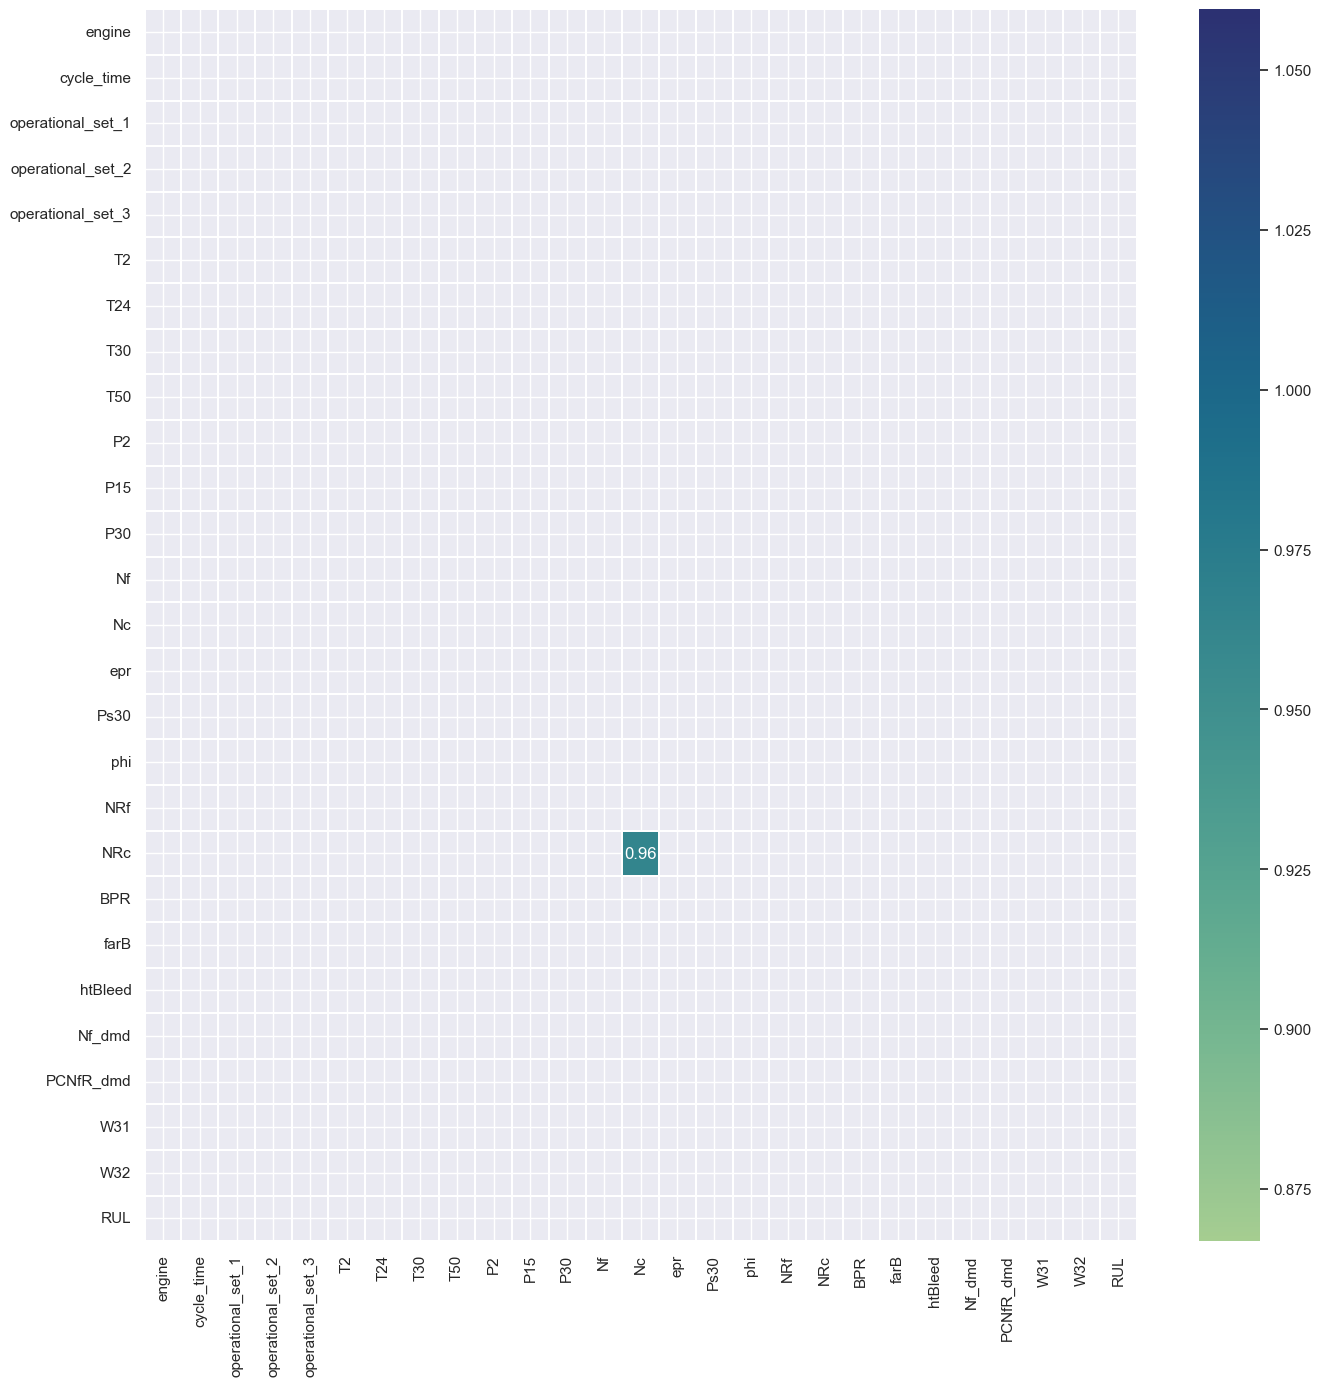

In [16]:
eda.plot_all()

### Data cleansing & Specific EDA

In [17]:
# Fine 3 shorter RUL cases and 3 longer RUL cases as an example
mins = failure_time.sort_values(by="cycle_time")[:3]["engine"].to_list()
maxs = failure_time.sort_values(by="cycle_time", ascending=False)[:3]["engine"].to_list()
print("3 engines shorter cycle_time:", mins)
print("3 engines longer cycle_time:", maxs)
cols = mins + maxs
print("Engines to be plotted:", cols)

3 engines shorter cycle_time: [39, 91, 70]
3 engines longer cycle_time: [69, 92, 96]
Engines to be plotted: [39, 91, 70, 69, 92, 96]


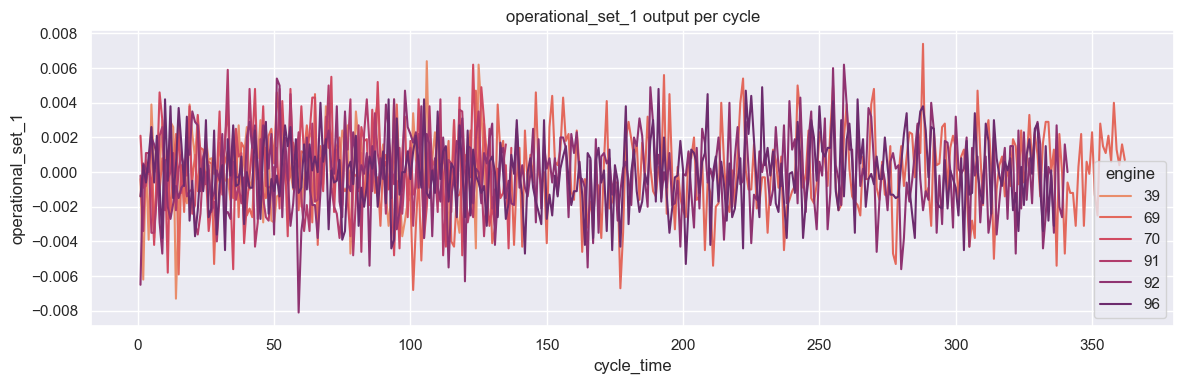

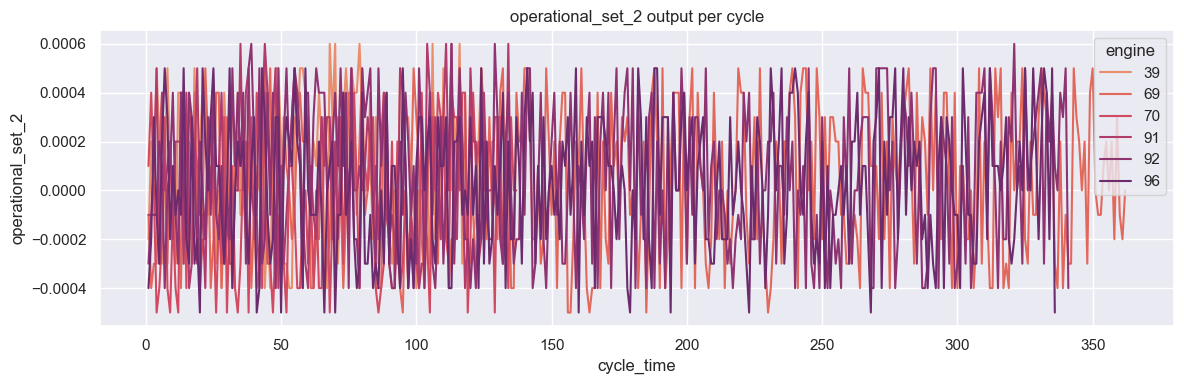

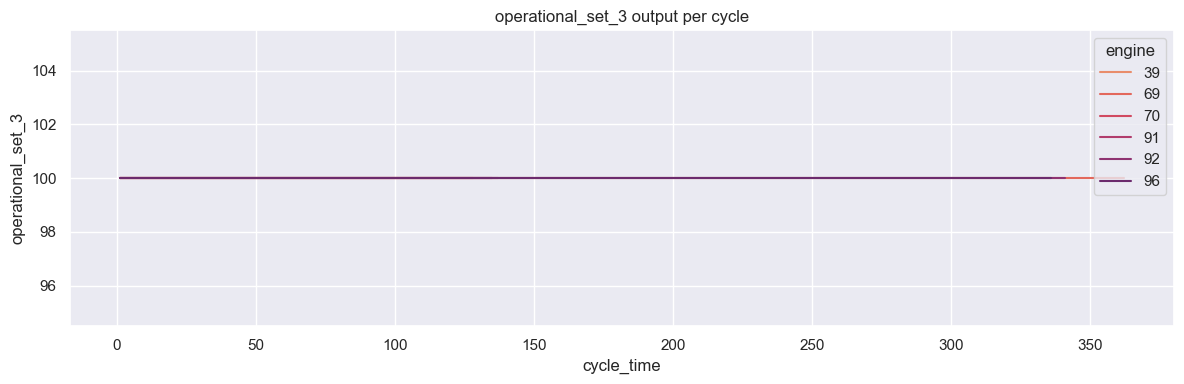

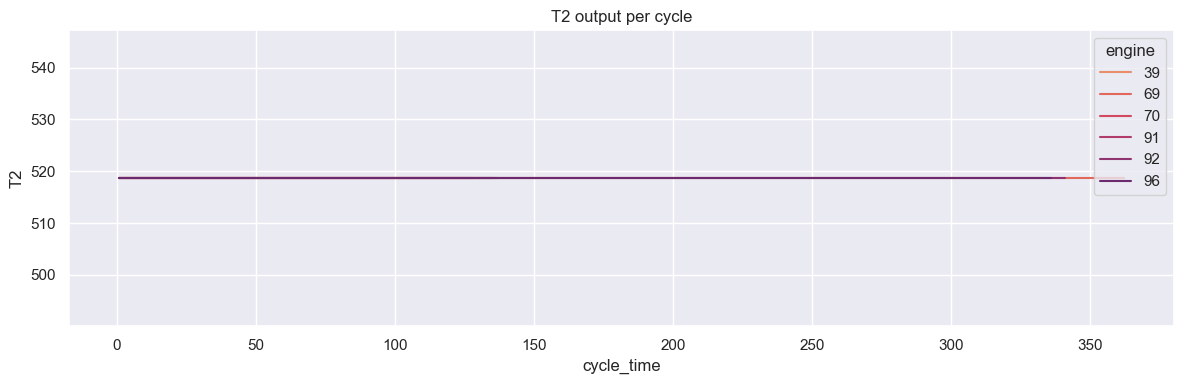

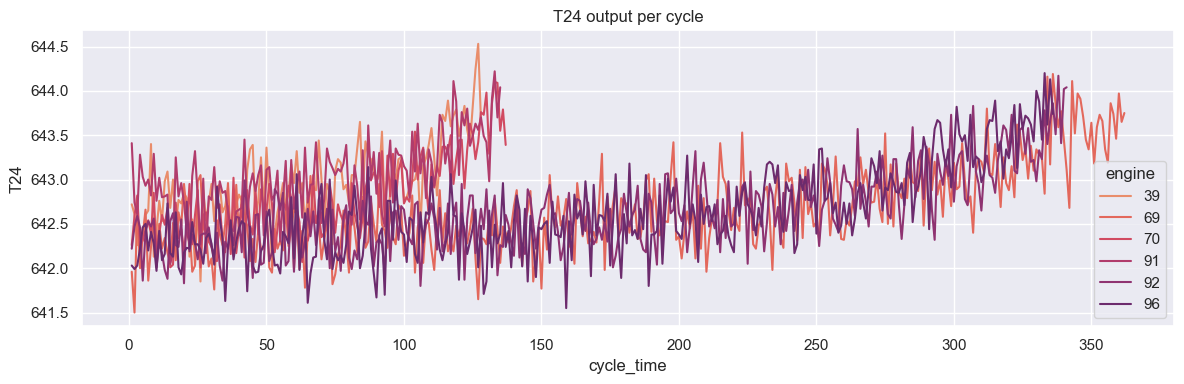

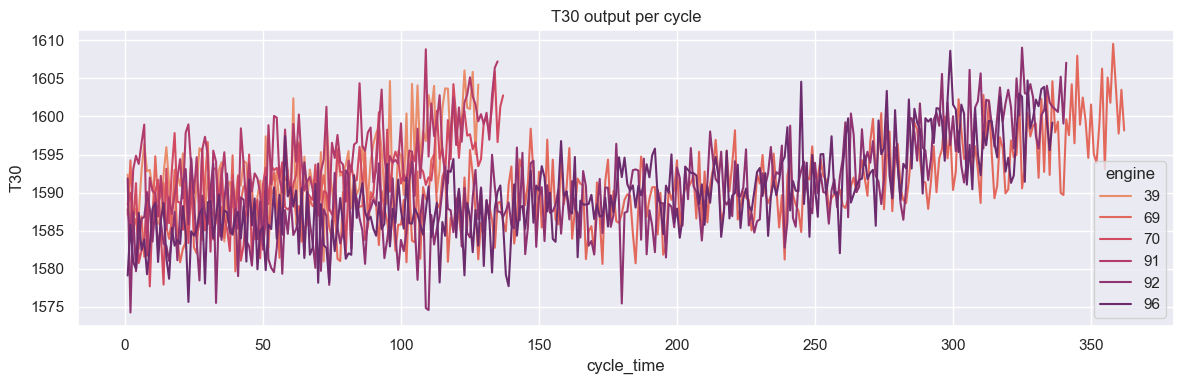

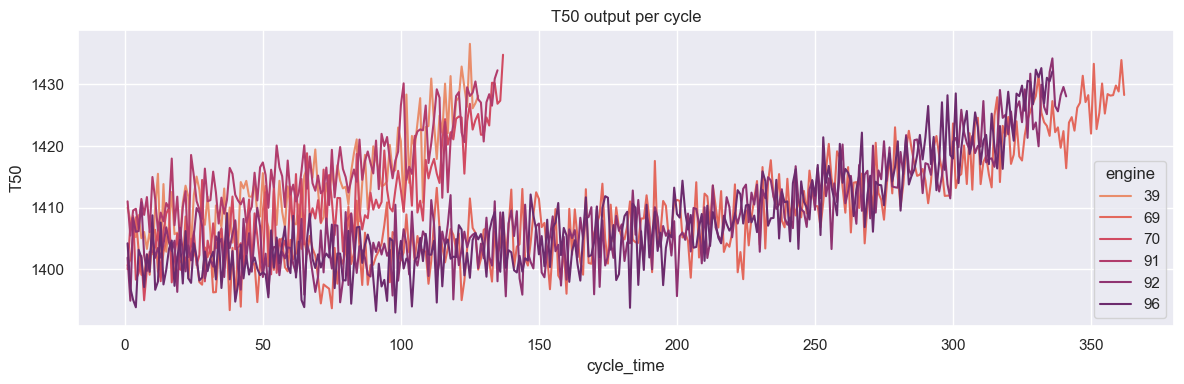

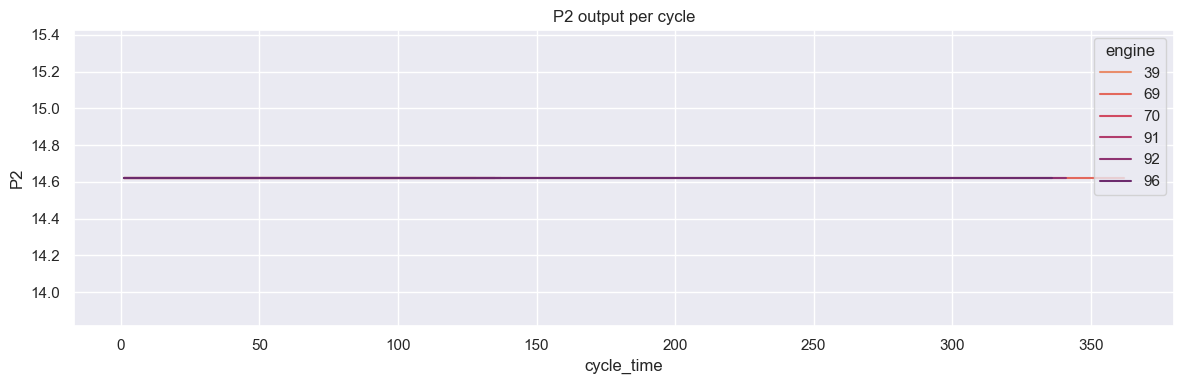

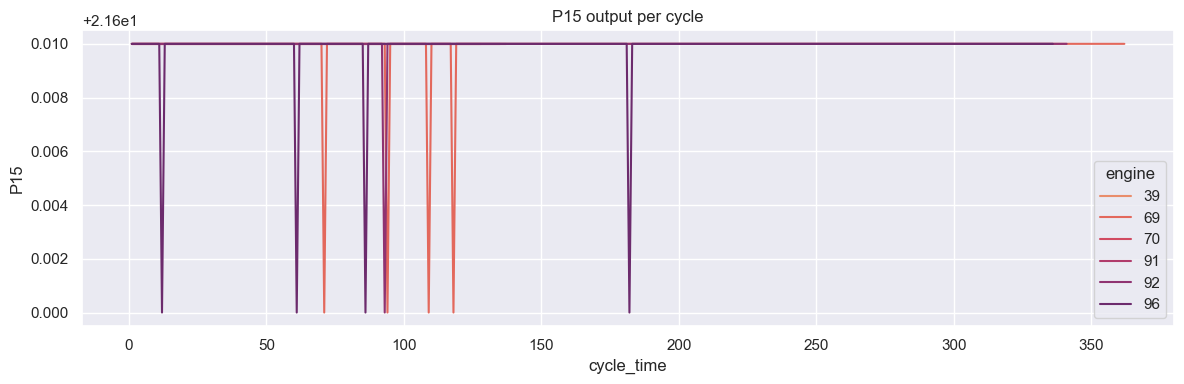

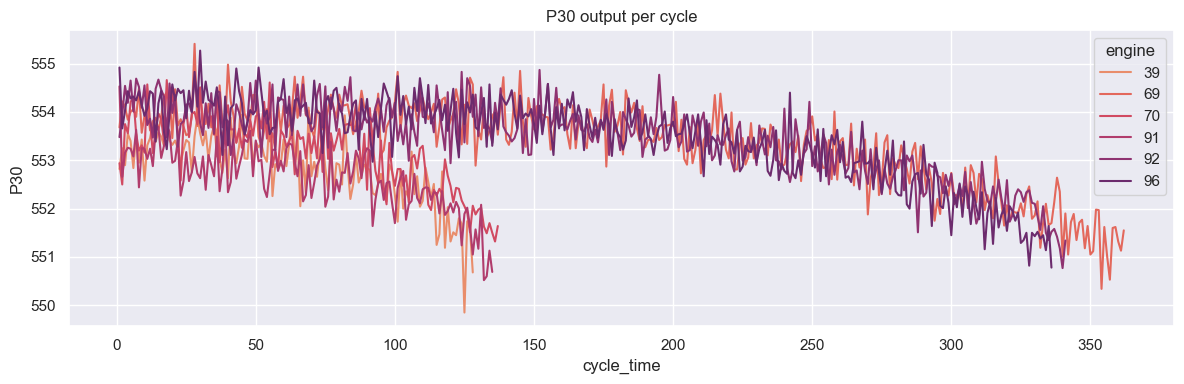

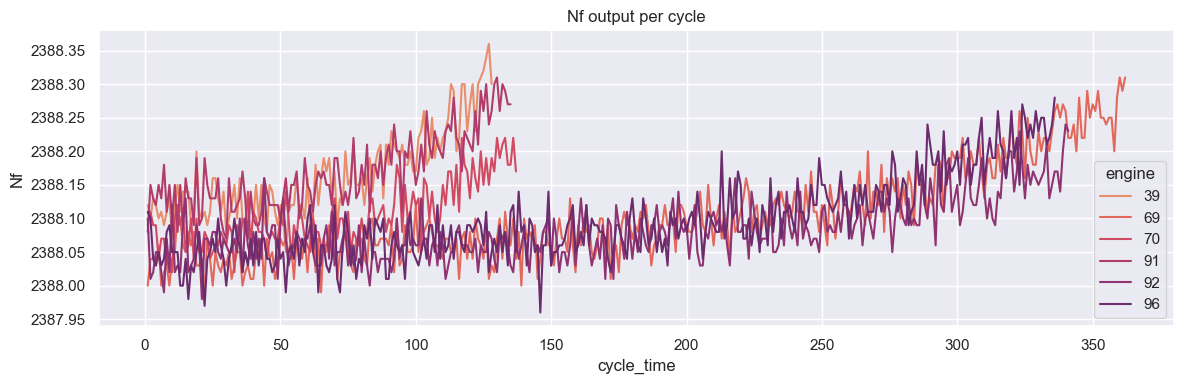

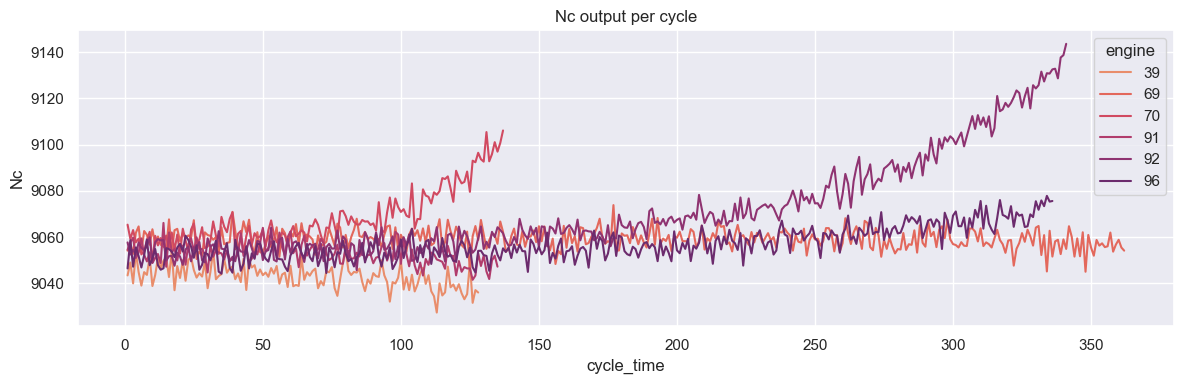

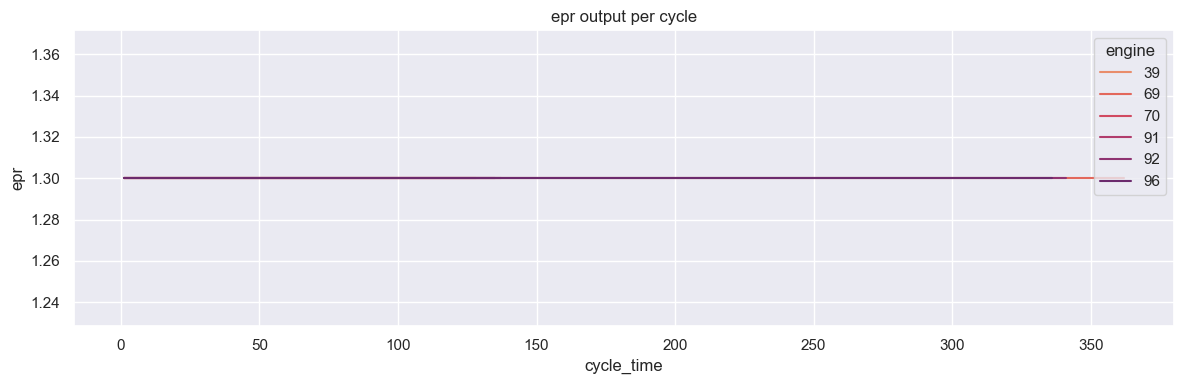

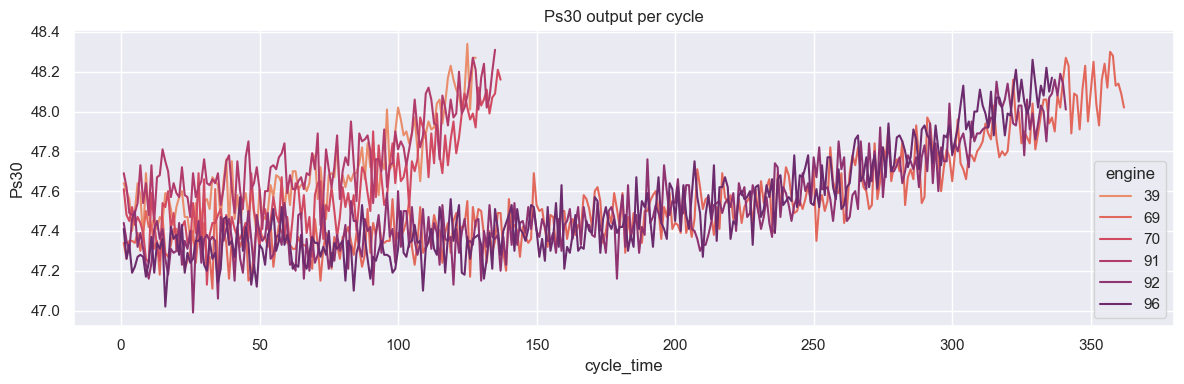

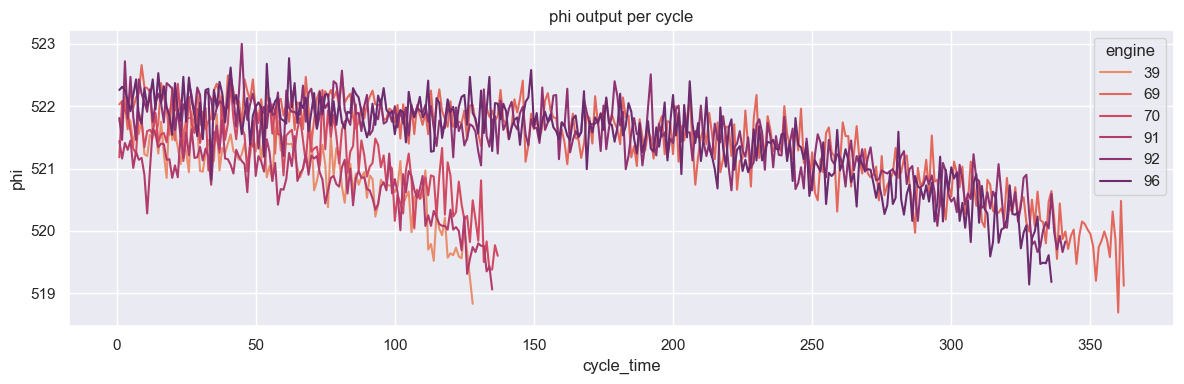

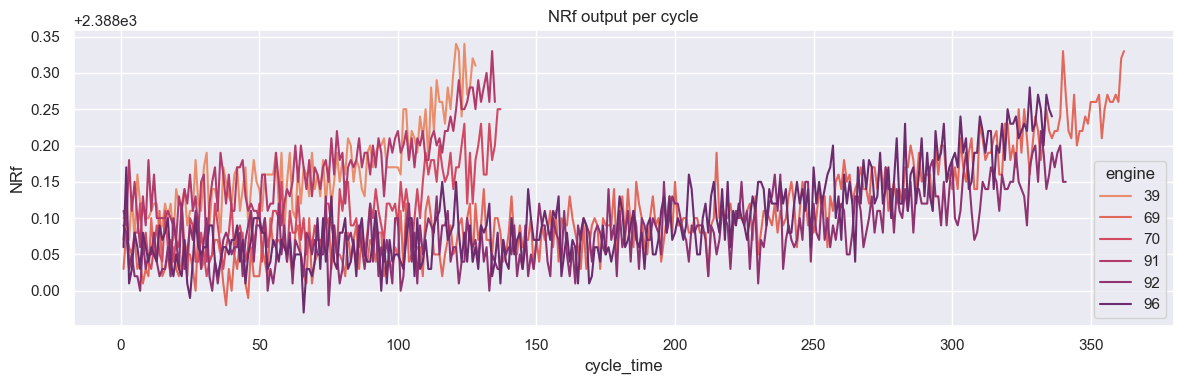

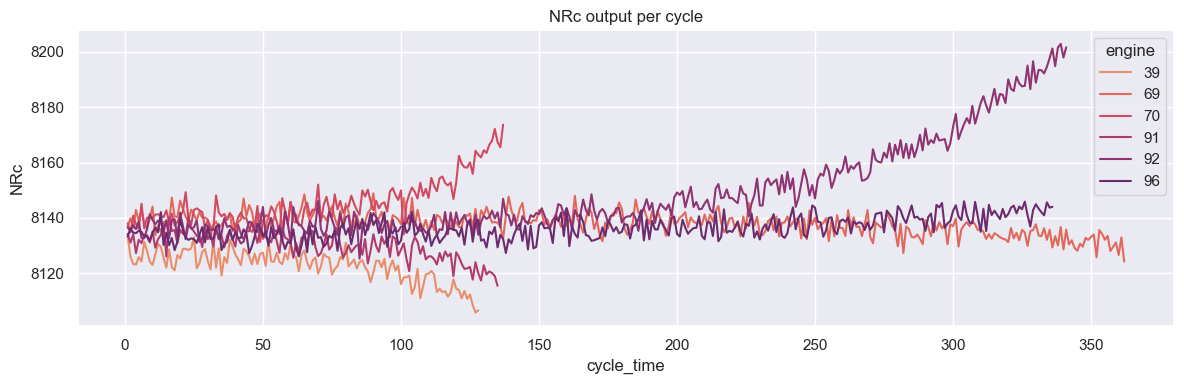

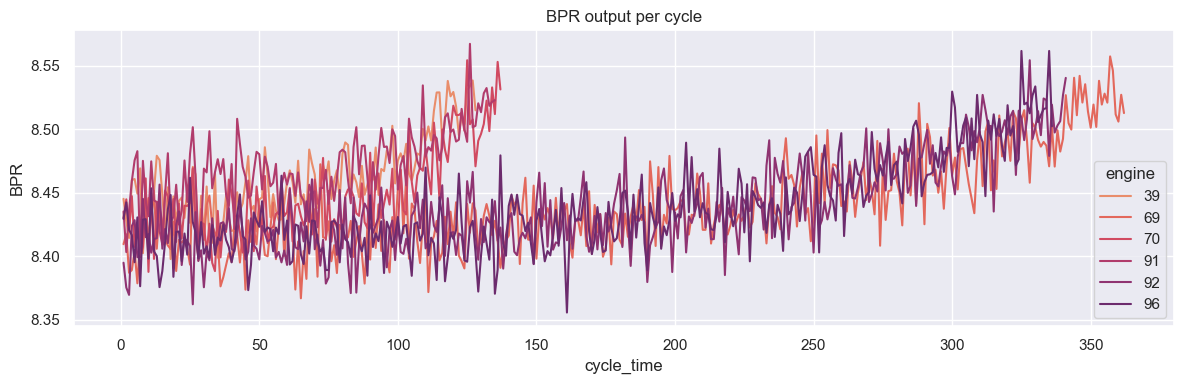

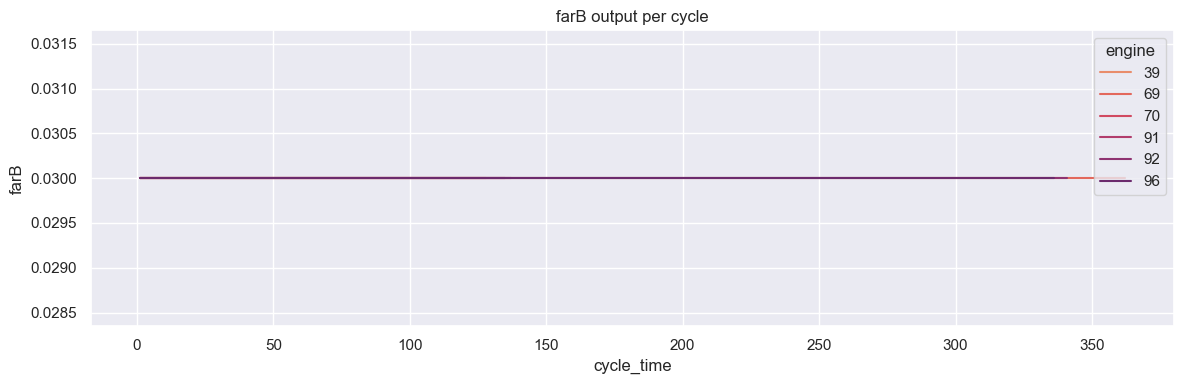

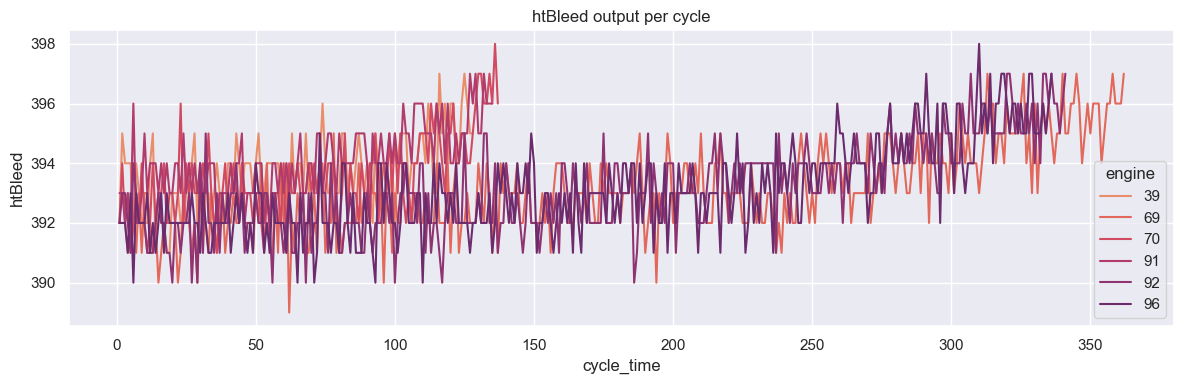

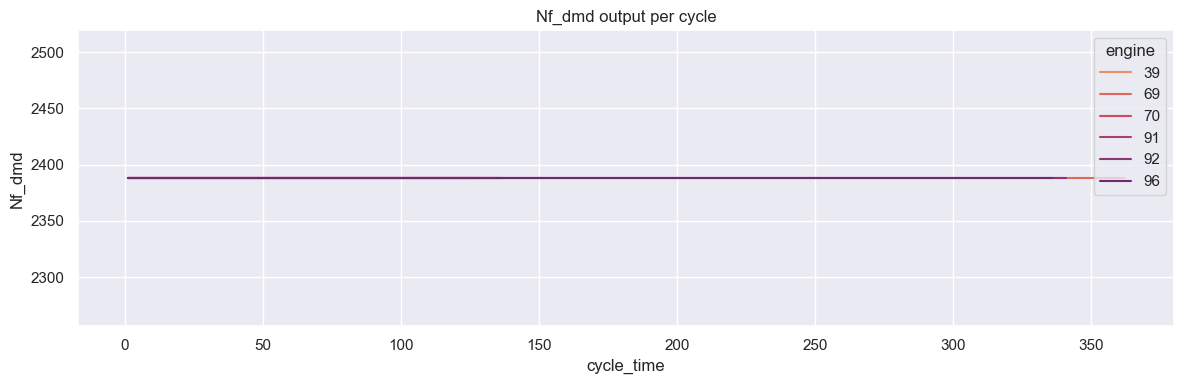

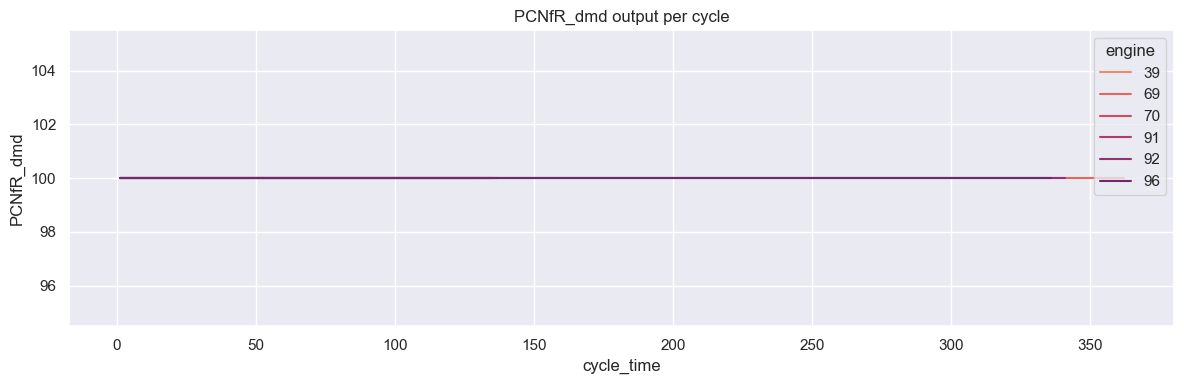

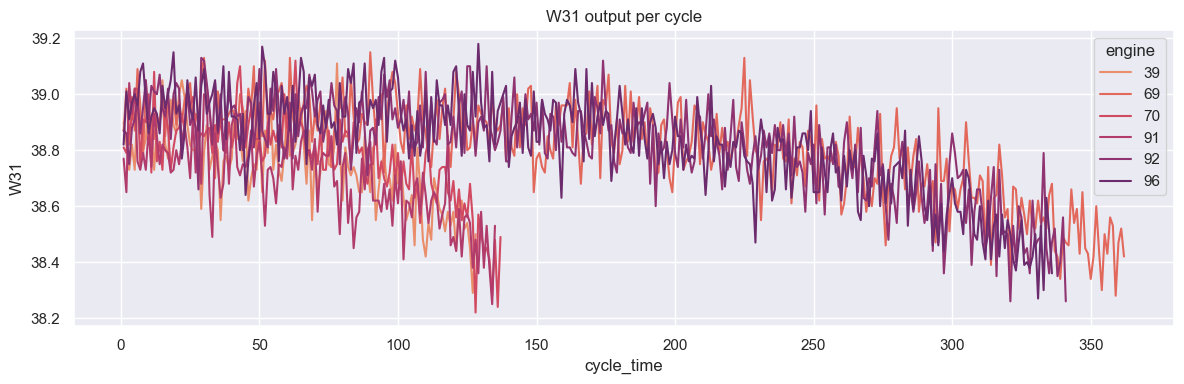

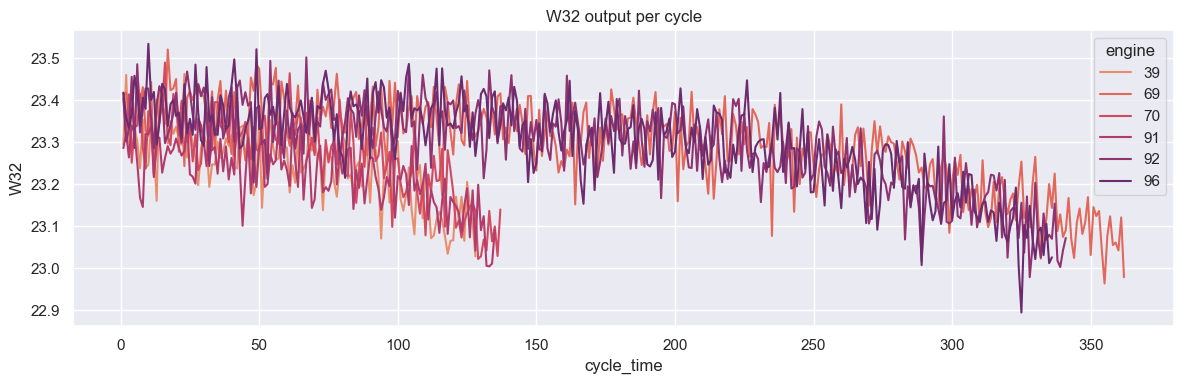

In [18]:
# Plot trends of each feature
pallete = sns.color_palette("flare", 6)

for col in [i for i in train_df.columns if i not in ["engine", "cycle_time", "RUL"]]:
    plt.figure(figsize=(12,4))
    sns.set_theme()
    sns.lineplot(data=train_df[train_df["engine"].isin(cols)], x="cycle_time", y=col, hue="engine", palette=pallete)
    plt.title(f"{col} output per cycle")
    plt.tight_layout()
    plt.show()

## Feature selection & engineering

In [19]:
"""Feature enginerring."""

import pandas as pd
from typing import Union

def remove_col(df: pd.DataFrame, col: Union[str, list]) -> pd.DataFrame:
    df.drop(columns=col, inplace=True)
    return df

def normalize_by_first_n_values(df: pd.DataFrame, grp_col: Union[str, list], features: Union[str, list] = None, rolling: int = 1) -> pd.DataFrame:
    start_value = df.groupby(grp_col).transform(lambda x: x.iloc[:rolling].mean())

    if features:
        df[features] = df[features] / start_value[features]
    else:
        df = df /start_value

    return df

def cliping(df: pd.DataFrame, col: Union[str, list], value: Union[int, float]) -> pd.DataFrame:
    df[col] = df[col].clip(upper=value)

    return df

In [20]:
# drop columns of operational setting and which have an unique value
drop_cols = ["operational_set_1", "operational_set_2", "operational_set_3", "T2", "P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
train_df = remove_col(train_df, drop_cols)
test_df = remove_col(test_df, drop_cols)

In [21]:
# check static of failure timing on train for further modification
print("train data, failure timing")
print("average =", int(failure_time["cycle_time"].mean()))
print("median =", int(failure_time["cycle_time"].median()))
print("min = ", failure_time["cycle_time"].min())
print("max = ", failure_time["cycle_time"].max())
print("0.25 quantile = ", failure_time["cycle_time"].quantile(0.25))
print("0.75 quantile = ", failure_time["cycle_time"].quantile(0.75))

train data, failure timing
average = 206
median = 199
min =  128
max =  362
0.25 quantile =  177.0
0.75 quantile =  229.25


In [22]:
# Normilization of sensor signal by first 10 values with smoothing average
grp_col = "engine"
features = [i for i in train_df.columns if i not in ["engine", "cycle_time", "RUL"]]
train_df = normalize_by_first_n_values(train_df, grp_col, features, 10)
test_df = normalize_by_first_n_values(test_df, grp_col, features, 10)

print(train_df.head())
print(test_df.head())


   engine  cycle_time       T24       T30       T50       P30        Nf  \
0       1           1  0.999407  1.001252  0.999829  1.000476  1.000005   
1       1           2  0.999921  1.002587  1.001642  0.999376  0.999996   
2       1           3  1.000232  1.000175  1.002399  1.000296  1.000013   
3       1           4  1.000232  0.996900  1.000735  1.000639  1.000026   
4       1           5  1.000263  0.996938  1.003841  0.999827  1.000005   

         Nc      Ps30       phi       NRf       NRc       BPR   htBleed  \
0  0.999628  1.004189  0.999069  0.999990  1.000786  1.001321  1.000510   
1  0.999393  1.004612  1.000257  1.000011  0.999909  1.002784  1.000510   
2  1.000373  0.999958  1.000525  0.999994  1.000123  1.001119  0.995406   
3  0.999991  0.996996  1.001367  1.000015  1.000197  0.995220  1.000510   
4  1.000618  1.000169  1.000084  0.999998  1.000193  1.002499  1.003063   

        W31       W32  RUL  
0  1.001950  1.001257  191  
1  1.000410  1.001454  190  
2  0.999128

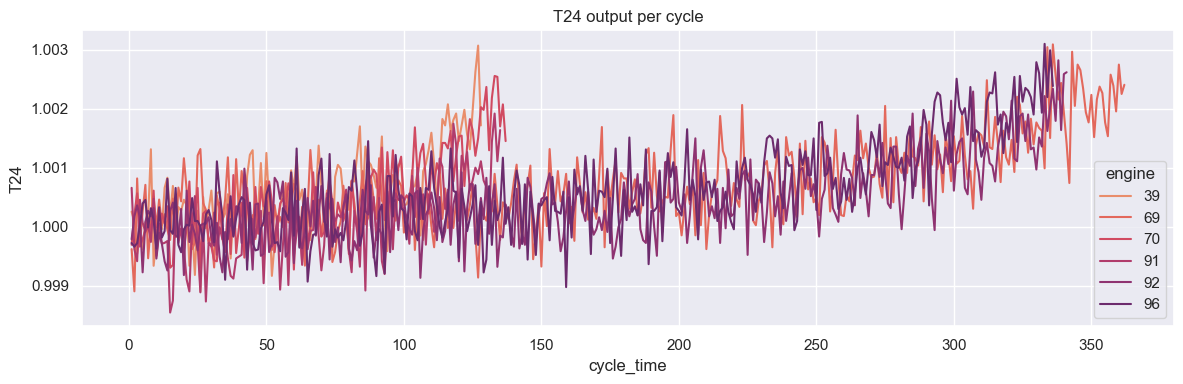

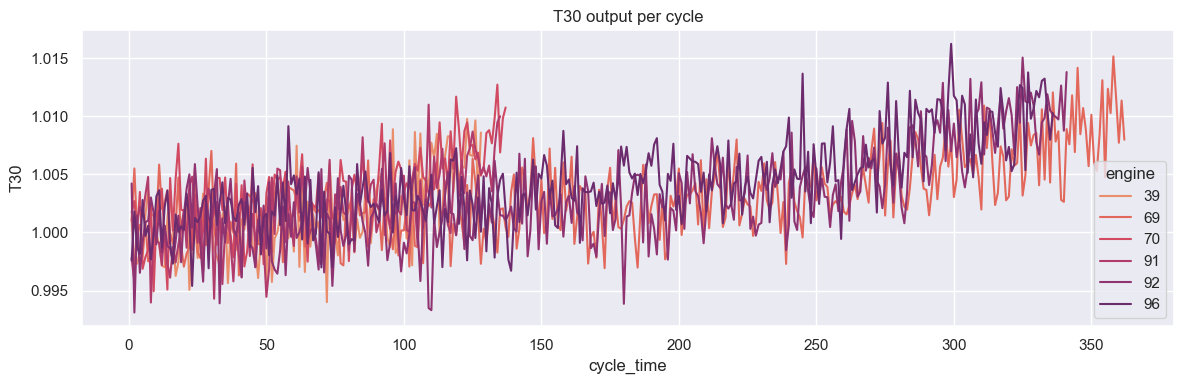

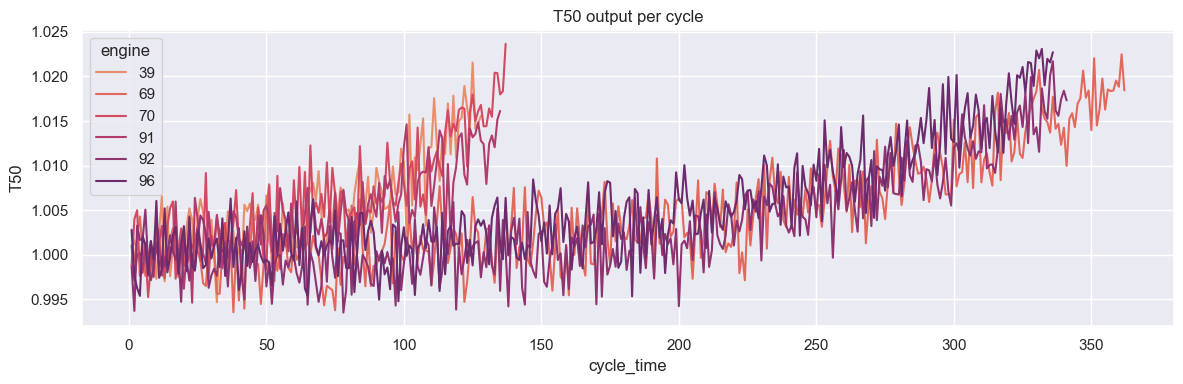

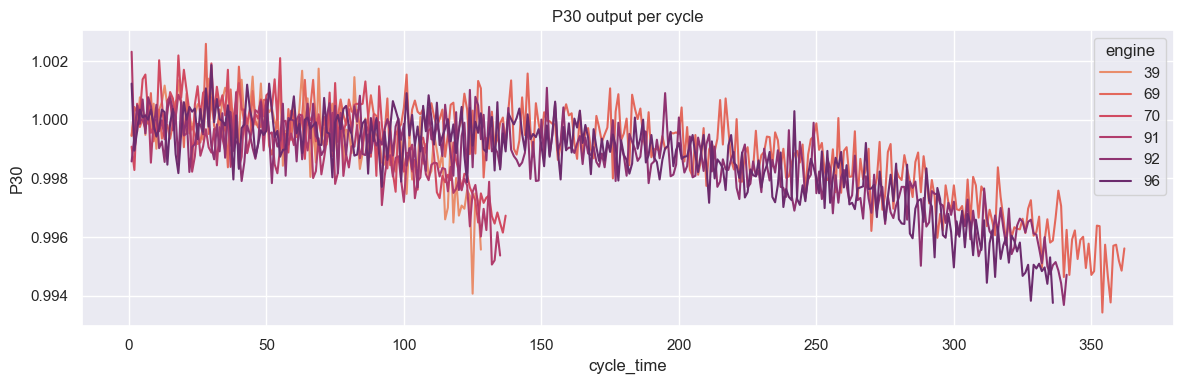

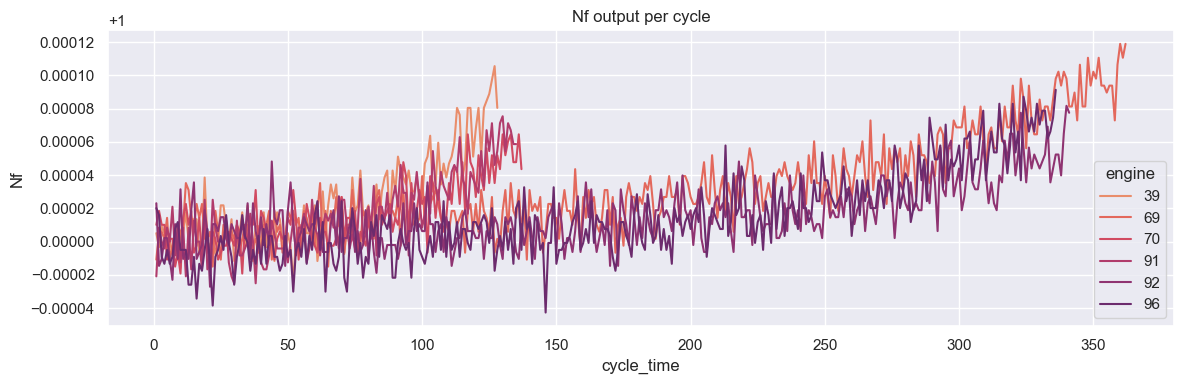

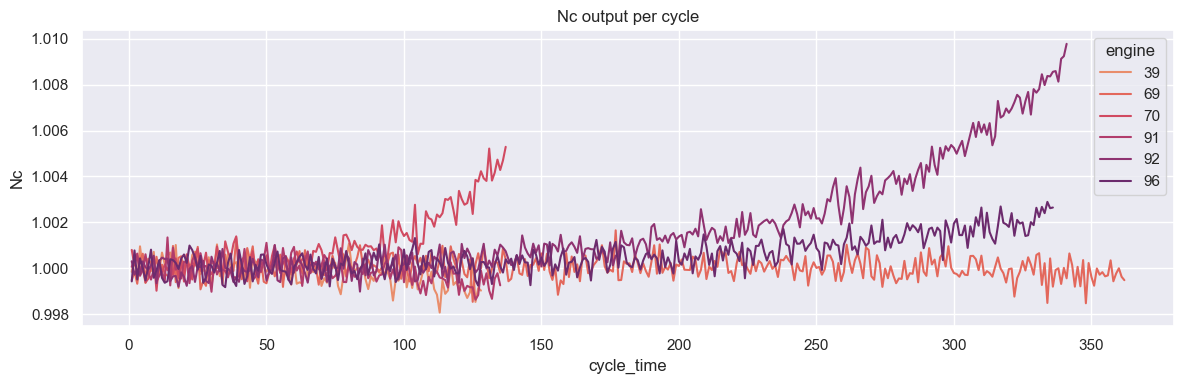

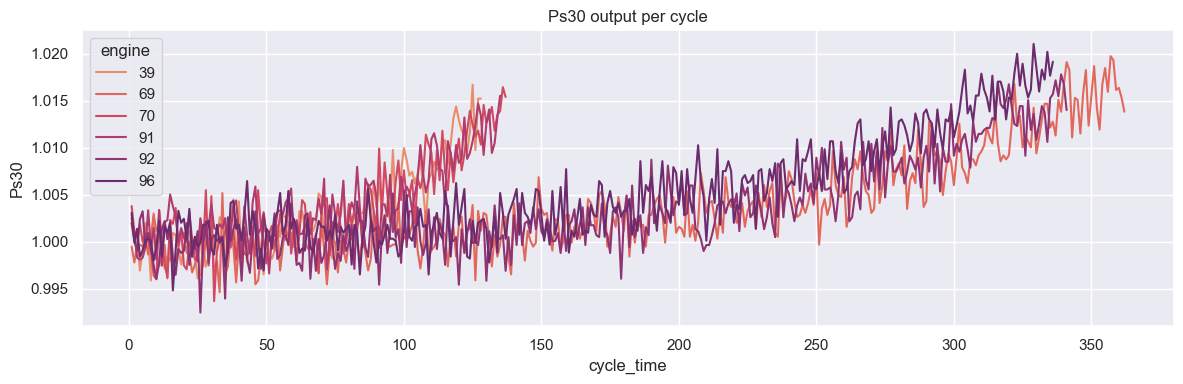

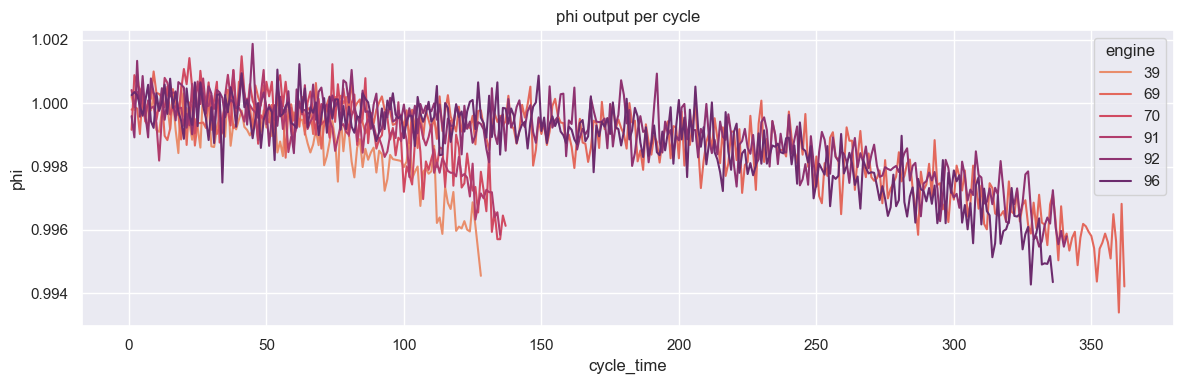

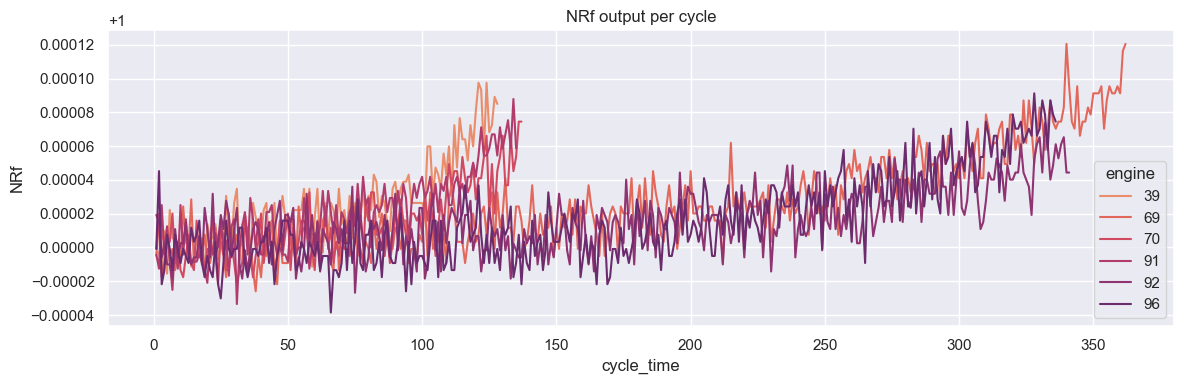

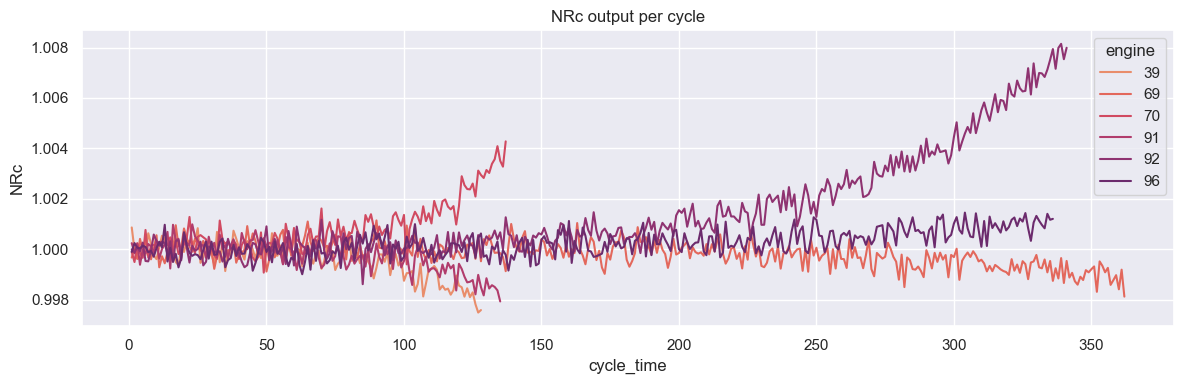

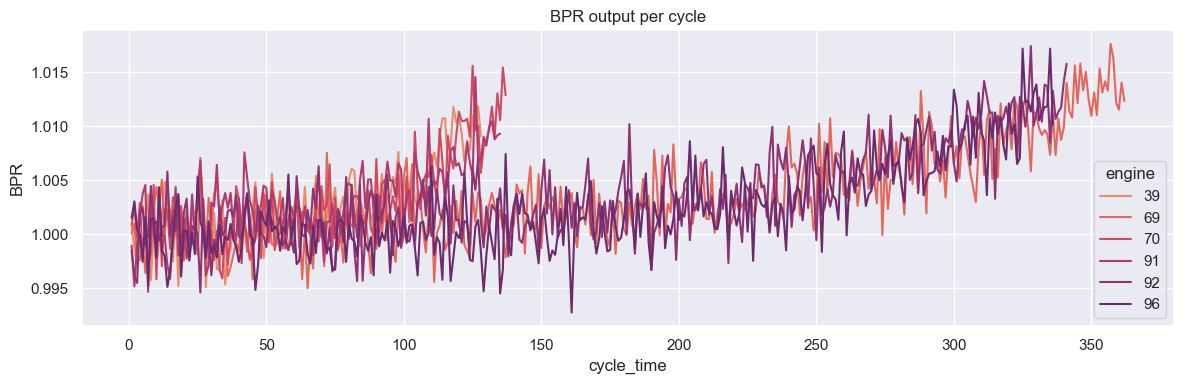

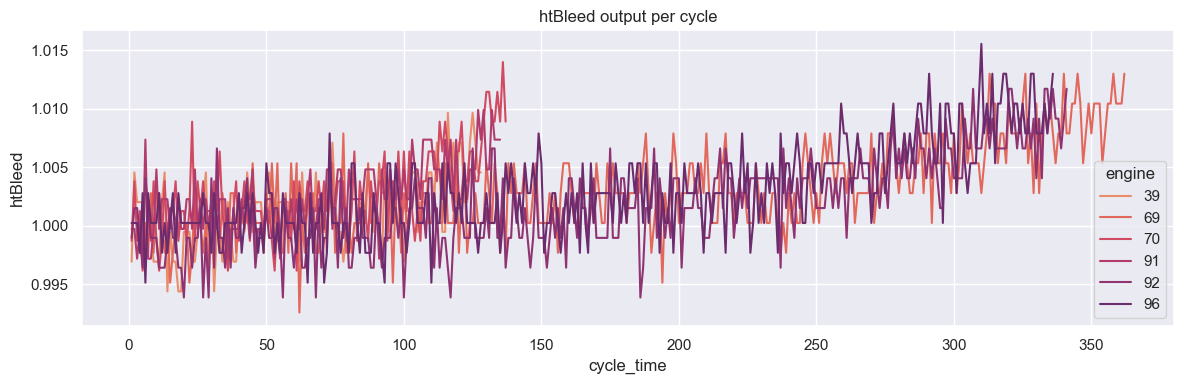

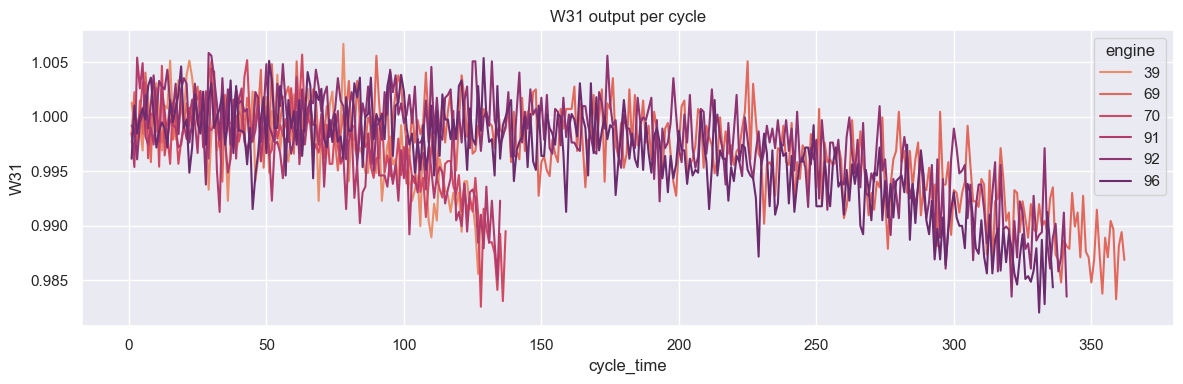

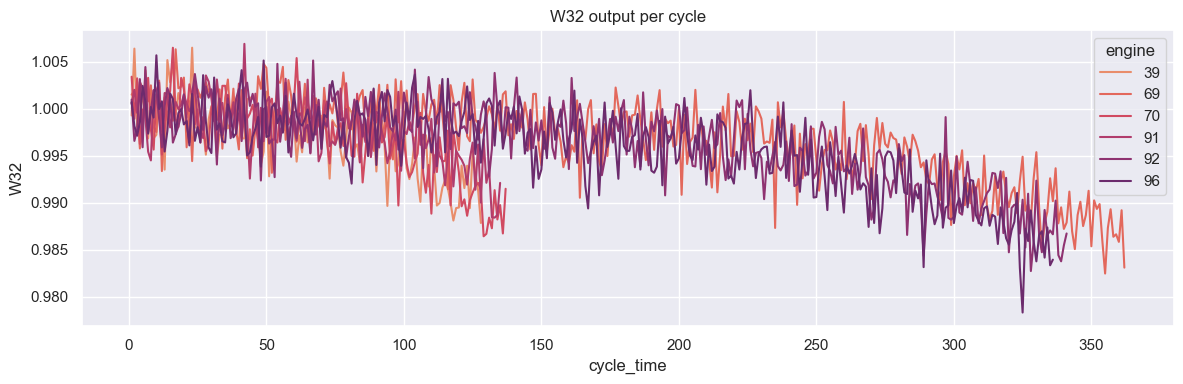

In [23]:
# Plot trends of each feature
pallete = sns.color_palette("flare", 6)

for col in [i for i in train_df.columns if i not in ["engine", "cycle_time", "RUL"]]:
    plt.figure(figsize=(12,4))
    sns.set_theme()
    sns.lineplot(data=train_df[train_df["engine"].isin(cols)], x="cycle_time", y=col, hue="engine", palette=pallete)
    plt.title(f"{col} output per cycle")
    plt.tight_layout()
    plt.show()

Numerical columns
Index(['engine', 'cycle_time', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',
       'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'RUL'],
      dtype='object')
--------
Categorical columns
Index([], dtype='object')
--------
Target column


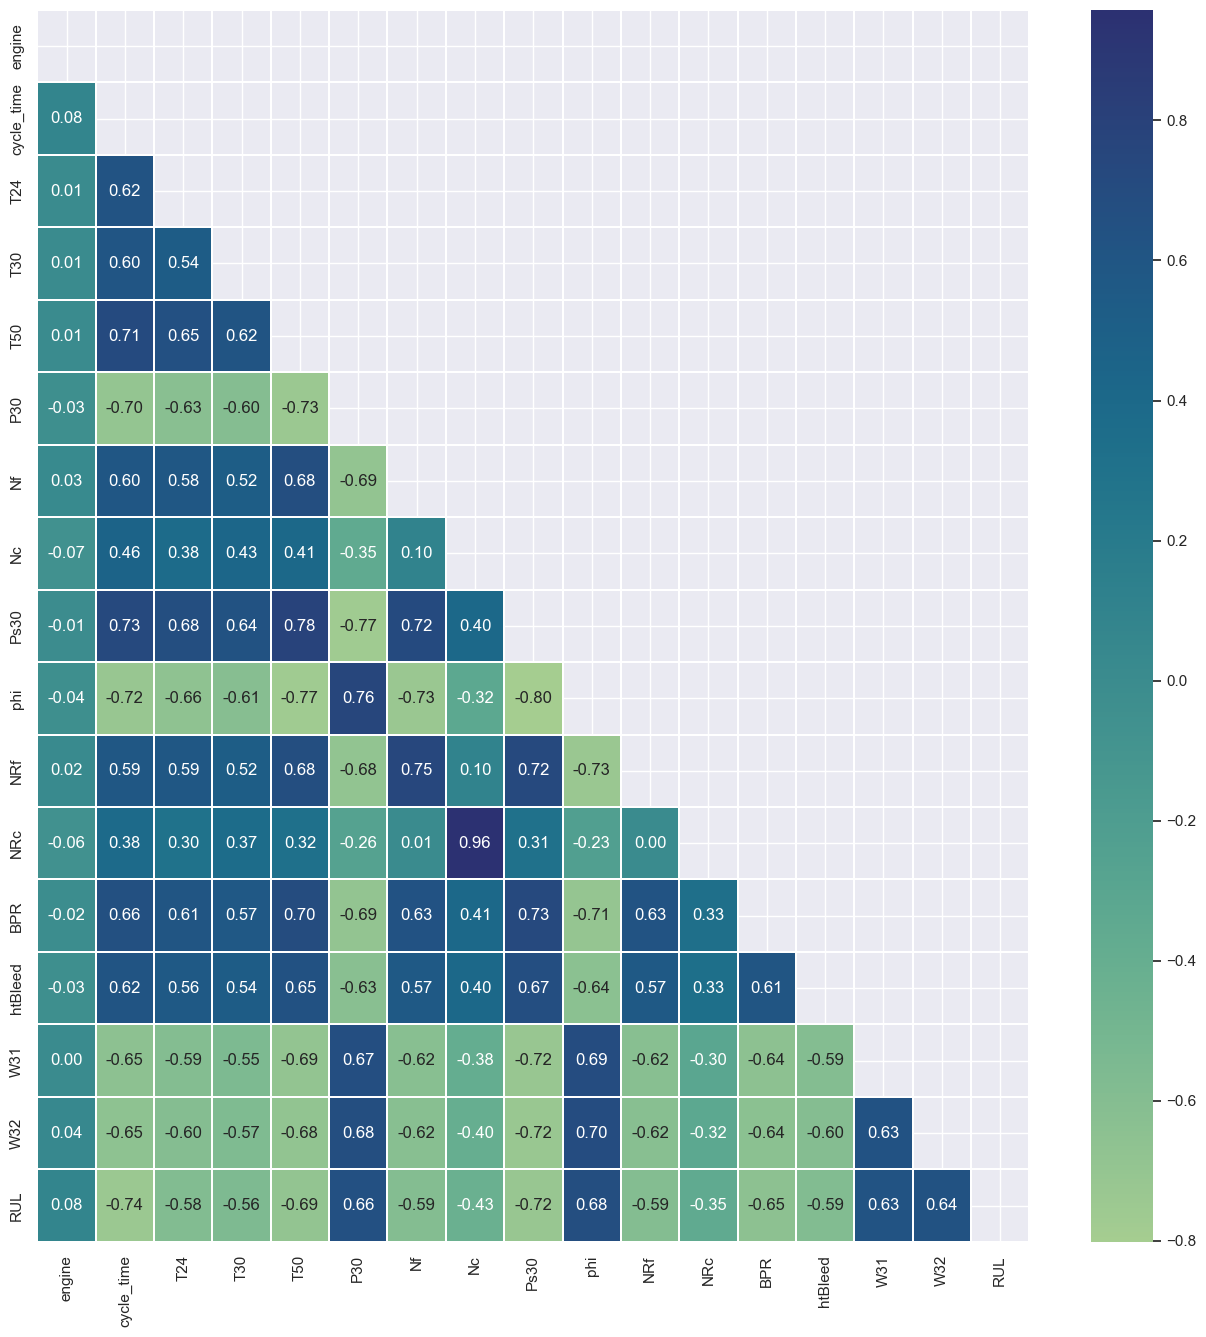

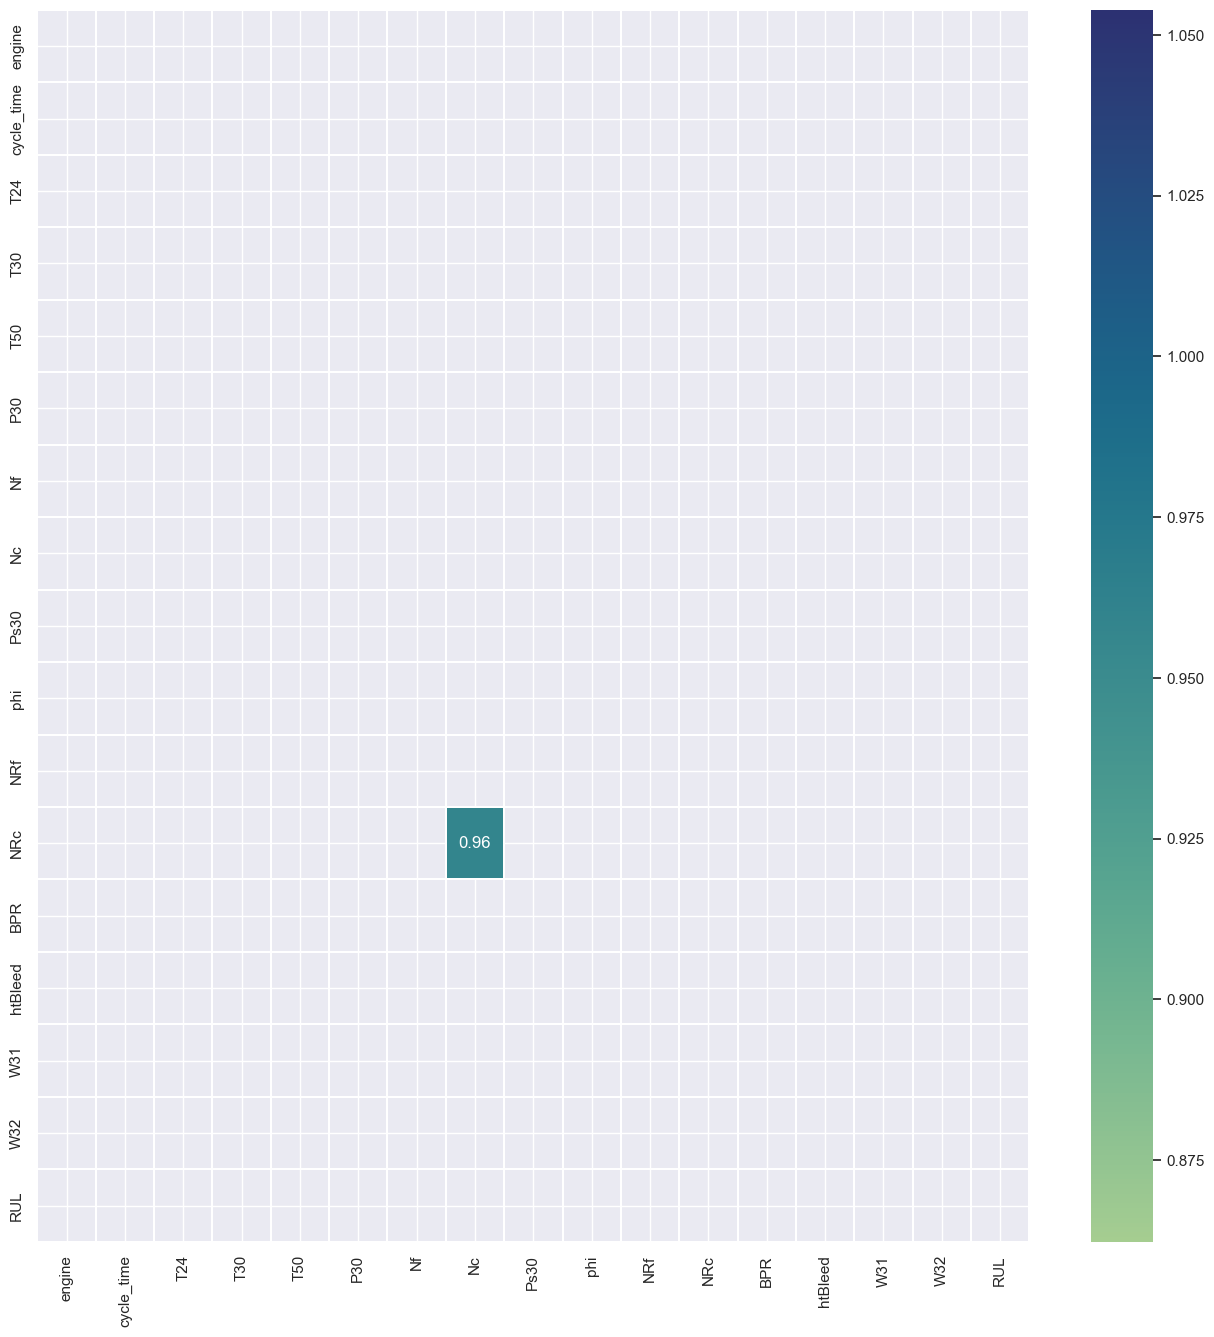

In [24]:
# correlation heatmap with selected columns
eda2 = EDA(train_df)
eda2.corr_plot()

In [ ]:
# highly correlated columns (corr > 0.9)

add_drop_cols = ["NRc"]

train_df = remove_col(train_df, add_drop_cols)
test_df = remove_col(test_df, add_drop_cols)

In [21]:
# we are not so interesting in RULs which are not requiring maintenance, thus we set up a upper limit from historical data * 0.95 (as safetynet)
# This allows to avoid over prediction

min_failure_time = int(failure_time["cycle_time"].min()*0.95)
train_df = cliping(train_df, "RUL", min_failure_time)
train_df.head()

engine  cycle_time       T24       T30       T50       P30        Nf  \
0       1           1  0.999407  1.001252  0.999829  1.000476  1.000005   
1       1           2  0.999921  1.002587  1.001642  0.999376  0.999996   
2       1           3  1.000232  1.000175  1.002399  1.000296  1.000013   
3       1           4  1.000232  0.996900  1.000735  1.000639  1.000026   
4       1           5  1.000263  0.996938  1.003841  0.999827  1.000005   

         Nc      Ps30       phi       NRf       BPR   htBleed       W31  \
0  0.999628  1.004189  0.999069  0.999990  1.001321  1.000510  1.001950   
1  0.999393  1.004612  1.000257  1.000011  1.002784  1.000510  1.000410   
2  1.000373  0.999958  1.000525  0.999994  1.001119  0.995406  0.999128   
3  0.999991  0.996996  1.001367  1.000015  0.995220  1.000510  0.997332   
4  1.000618  1.000169  1.000084  0.999998  1.002499  1.003063  0.997845   

        W32  RUL  
0  1.001257  121  
1  1.001454  121  
2  0.998059  121  
3  0.999329  121  
4  1.000633  121

# Predictive model

## Data prep

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split

# set up feature and target columns
features = [i for i in train_df.columns if i not in ["engine", "RUL"]]
target_col = "RUL"

print("features:", features)
print("taget:", target_col)

# store data
train_X_std = train_df[features]
y = train_df[target_col]

# data split
train_X, val_X, train_y, val_y = train_test_split(train_X_std, y, test_size=0.2, random_state=42)

features: ['cycle_time', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
taget: RUL


## Modelling: Hyper param tuning & Evaluation

### Define models - regression

In [ ]:
import lightgbm as lgb
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR

# define models as dict
models = {
    "linear": LinearRegression(),
    "elastic": ElasticNet(),
    "svr": SVR(),
    "random_forest": RandomForestRegressor(),
    "lightgbm": lgb.LGBMRegressor(),
    "xgboost": xgb.XGBRegressor(),
}

### hyper parameter tuning with grid search CV 

In [ ]:
params = {
    "linear": {},
    "elastic": {
        "alpha": [0.1, 1, 10],
        "l1_ratio": [0.4, 0.5, 0.6],
        "tol": [0.0001, 0.001],
    },
    "svr": {
        "kernel": ["rbf"],
        "C": [1, 10],
        "gamma": ["scale", "auto"],
    },
    "knn": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2, 3]
    },
    "random_forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
    },
    "lightgbm": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [5, 10, 15],
        "verbose": [-1],
    },
    "xgboost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [5, 10, 15],
    },
}

In [ ]:
"""Modules of repeated usage"""
import numpy as np
import pandas as pd

from typing import Union
from sklearn.model_selection import GridSearchCV


def hyperparam_tuning_gs(model, params: dict, X: pd.DataFrame, y: Union[pd.DataFrame, pd.Series, np.array], scoring: str, cv: int = None) -> dict:
    """Hyper parameter tuning by grid search with cross validation.

    Variables
    ----------
    model: Estimator
        Model estimater (initialized one not trained model)
    params: dict
        Hyper paramters
    X: pd.DataFrame
        Dataframe only with feature columns
    y: pd.DataFrame | pd.Series |
        Dataframe only with feature columns
    cv: int
        Number of split for X-validation
    ----------

    Outputs
    ----------
    best_params: dict
        Hyper parameter from the best model
    ----------
    """
    if cv:
        # use when we specific fold numbers for cv
        gridsearch = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring=scoring)
        gridsearch.fit(X, y)
    else:
        # cv = 5 (default) will be applied.
        gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring)
        gridsearch.fit(X, y)

    # store best result
    best_est = gridsearch.best_estimator_
    best_params = gridsearch.best_params_
    best_score = gridsearch.best_score_

    print("best params:", best_params)
    print("best_score:", best_score)

    # return best estimator, params and score
    return best_est, best_params, best_score

In [ ]:
import time
from sklearn.metrics import mean_squared_error

best_models = {}
scoring = "neg_mean_squared_error"  # objective metrics

# loop grid search for parameter tuning
for model, estimator in models.items():
    print(f"Model: {model}")
    start_time = time.time()
    if len(params[model]) == 0:
        print("Hyperparmeters not defined. Training with default params.")
        estimator.fit(train_X, train_y)
        pred_y = estimator.predict(train_X)
        end_time = time.time()
        score = mean_squared_error(train_y, pred_y)*(-1)  # To make negative mse to be inline with others
        print("best_score:", score)
        best_models[model] = {"estimator": estimator, "params": {}, "score": score}
        print("Execution time: %s seconds" %(end_time - start_time))
        print(f"-----------")
        continue
    print(params[model])
    best_est, best_params, best_score = hyperparam_tuning_gs(estimator, params[model], train_X, train_y, scoring)
    end_time = time.time()
    best_models[model] = {"estimator": best_est, "params": best_params, "score": best_score}
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")


Model: linear
Hyperparmeters not defined. Training with default params.
best_score: -312.9718456564125
Execution time: 0.006478071212768555 seconds
-----------
Model: elastic
{'alpha': [0.1, 1, 10], 'l1_ratio': [0.4, 0.5, 0.6], 'tol': [0.0001, 0.001]}
best params: {'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}
best_score: -734.7111707901979
Execution time: 0.5455338954925537 seconds
-----------
Model: svr
{'kernel': ['rbf'], 'C': [1, 10], 'gamma': ['scale', 'auto']}
best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
best_score: -707.1861730222774
Execution time: 166.51962900161743 seconds
-----------
Model: random_forest
{'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
best params: {'max_depth': 15, 'n_estimators': 200}
best_score: -165.60668771270045
Execution time: 888.3560039997101 seconds
-----------
Model: lightgbm
{'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [5, 10, 15], 'verbose': [-1]}
best params: {'learning_rate': 0.1, 'm

### Model evalutation for train & validation data sets

In [ ]:
"""Model Evaluation"""

from sklearn.metrics import (
    accuracy_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    classification_report
)

def score(y_act, y_pred, model):
    """Evluate models.

    Variables
    ----------
    y_act: actual values (answers)
    y_pred: predicted values by model
    model: model speices (Regression or Classification)
    ----------

    Outputs
    ----------
    if Regression, then r2, mse & mae
    if Classification, then accuracy, confusion matrix & report
    ----------
    """
    # if model = Regression, then r2, mse and mae will be returned
    if "RegModel" in model:
        r2 = r2_score(y_act, y_pred)
        mse = mean_squared_error(y_act, y_pred)
        mae = mean_absolute_error(y_act, y_pred)

        return r2, mse, mae

    # if model = classification, then acc, confusion matrix and report will be returned
    elif "ClsModel" in model:
        acc = accuracy_score(y_act, y_pred)
        cm = confusion_matrix(y_act, y_pred)
        cr = classification_report(y_act, y_pred)
        
        return acc, cm, cr

    # if model not defined correctly, raise error
    else:
        raise ValueError("Model is not a Regression or a Classification model")

In [ ]:
# check train metrics

print("train data")

for m in models.keys():
    start_time = time.time()
    mdl = best_models[m]["estimator"]
    mdl_pred_y = mdl.predict(train_X)
    end_time = time.time()

    r2, mse, mae = score(train_y, mdl_pred_y, "RegModel")
    
    print(f"-----------")
    print("model:", m)
    print("r2 score:", r2)
    print("mse:", mse)
    print("mae:", mae)
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")

train test
-----------
model: linear
r2 score: 0.8076371120616633
mse: 312.9718456564125
mae: 14.129617669283709
Execution time: 0.0017819404602050781 seconds
-----------
-----------
model: elastic
r2 score: 0.5485541030115756
mse: 734.4964359225744
mae: 20.8539828967315
Execution time: 0.0009310245513916016 seconds
-----------
-----------
model: svr
r2 score: 0.5645658936590846
mse: 708.4454667105641
mae: 17.41550624867716
Execution time: 13.641845941543579 seconds
-----------
-----------
model: random_forest
r2 score: 0.9769690093882696
mse: 37.471113665954974
mae: 4.2223231040918074
Execution time: 0.47760796546936035 seconds
-----------
-----------
model: lightgbm
r2 score: 0.9686468168074711
mse: 51.011209678422446
mae: 4.935134932217449
Execution time: 0.0630042552947998 seconds
-----------
-----------
model: xgboost
r2 score: 0.9571681022644043
mse: 69.68693627820392
mae: 5.721112326656343
Execution time: 0.017143964767456055 seconds
-----------


In [ ]:
# check validation metrics

print("validation data")

for m in models.keys():
    start_time = time.time()
    mdl = best_models[m]["estimator"]
    mdl_pred_y = mdl.predict(val_X)
    end_time = time.time()
    
    r2, mse, mae = score(val_y, mdl_pred_y, "RegModel")

    print(f"-----------")
    print("model:", m)
    print("r2 score:", r2)
    print("mse:", mse)
    print("mae:", mae)
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")

validation data
-----------
model: linear
r2 score: 0.8121118268052906
mse: 296.8399928556315
mae: 13.775307643648999
Execution time: 0.002440929412841797 seconds
-----------
-----------
model: elastic
r2 score: 0.5625831390086817
mse: 691.0643479248637
mae: 20.082062542138857
Execution time: 0.0007190704345703125 seconds
-----------
-----------
model: svr
r2 score: 0.5823155592523487
mse: 659.8895731396279
mae: 16.67175378946755
Execution time: 3.5875821113586426 seconds
-----------
-----------
model: random_forest
r2 score: 0.9035049585676878
mse: 152.4501884410147
mae: 8.46834196910146
Execution time: 0.27463769912719727 seconds
-----------
-----------
model: lightgbm
r2 score: 0.925794945279603
mse: 117.2347760826205
mae: 7.313890406217269
Execution time: 0.02774190902709961 seconds
-----------
-----------
model: xgboost
r2 score: 0.9204603433609009
mse: 125.66275928825394
mae: 7.708903385069458
Execution time: 0.008931875228881836 seconds
-----------


## Model Selection based on Metrics

In [ ]:
# choose one best model based on score
best_model_key = max(best_models, key=lambda k: best_models[k]["score"])
selected_model = best_models[best_model_key]["estimator"]
print("Selected model:", best_model_key)
print("Params for model:", selected_model.get_params())
print("R2 Score of model:", best_models[best_model_key]["score"])

Selected model: lightgbm
Params for model: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}
R2 Score of model: -130.62913596680224


## Check feature importance, SHAP values & learning curve

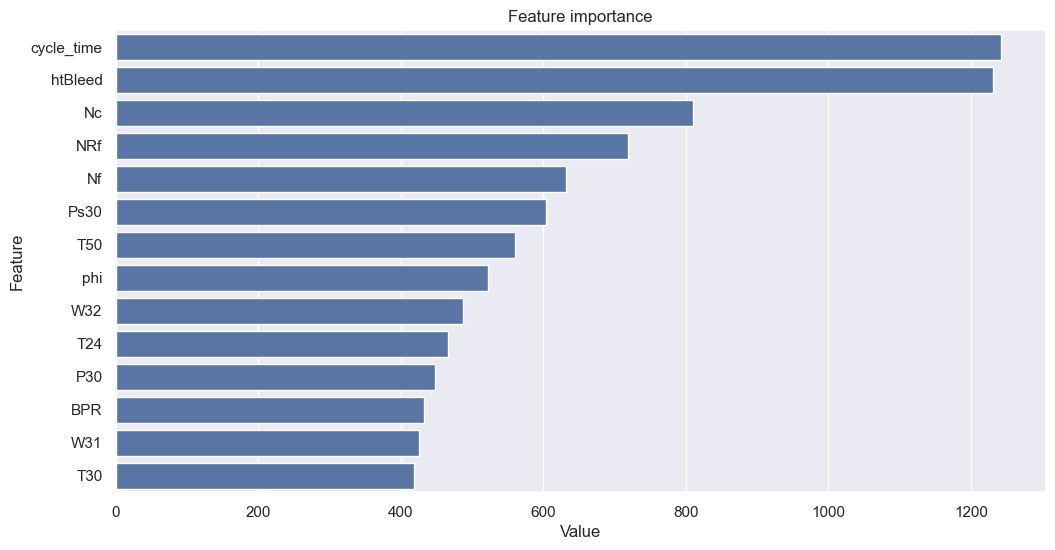

In [ ]:
# plot feature importance (LGBM)
feature_importance = pd.DataFrame(sorted(zip(selected_model.feature_importances_, train_X_std.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.set_theme()
sns.barplot(data=feature_importance.sort_values(by="Value", ascending=False), x="Value", y="Feature")
plt.title("Feature importance")
plt.show()

In [25]:
import shap

explainer = shap.TreeExplainer(selected_model)
X = pd.DataFrame(val_X, columns=train_df[features].columns)
shap_feature = X.columns
sv = explainer(X)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


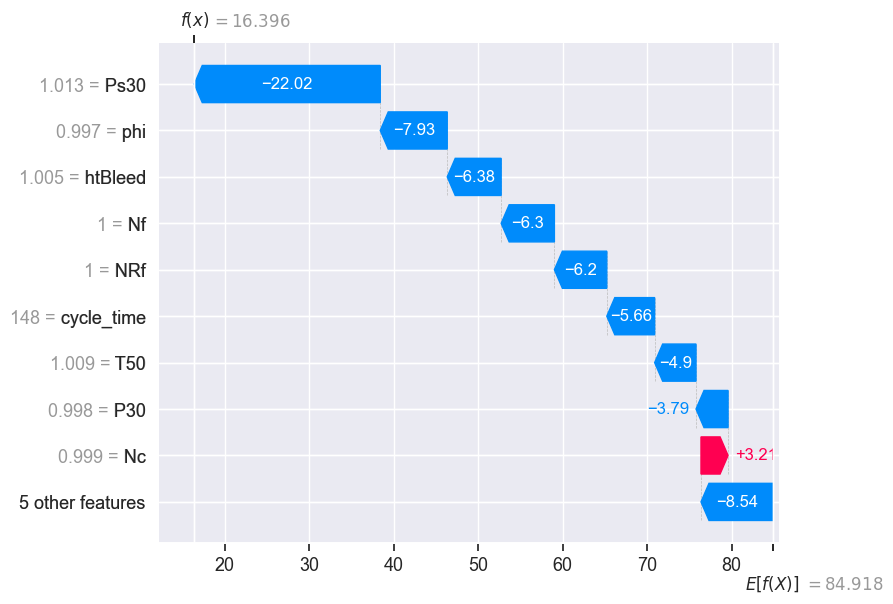

In [26]:
shap.plots.waterfall(sv[1])

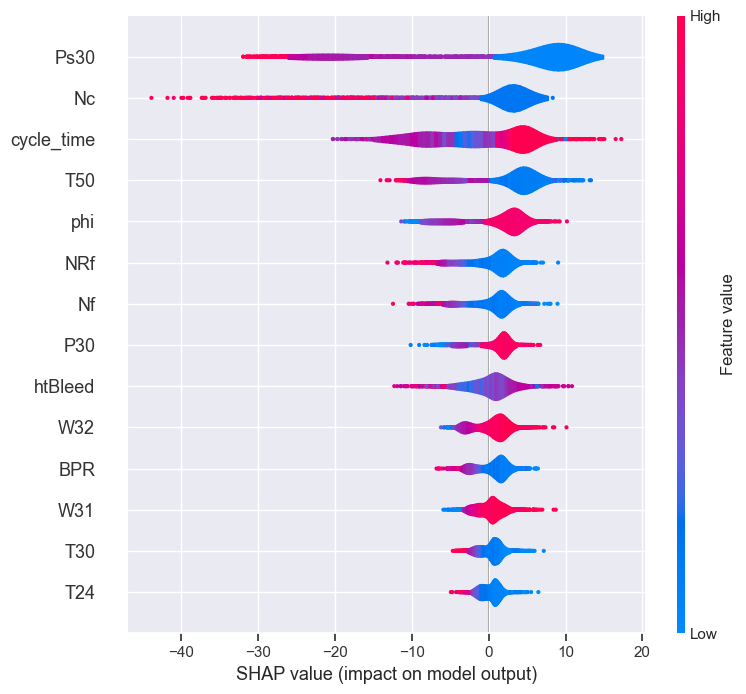

In [27]:
shap.summary_plot(sv, feature_names=shap_feature, plot_type="violin")


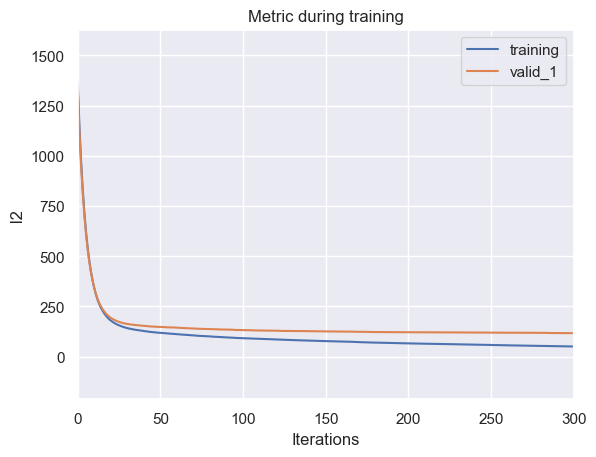

In [ ]:
# Learning curve (LGBM)
mdl = selected_model
mdl.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)])
_ = lgb.plot_metric(mdl)

In [ ]:
# recheck validation metrics
pred_y = selected_model.predict(val_X)
r2, mse, mae = score(val_y, pred_y, "RegModel")

print("Bset model:", selected_model)
print("r2 score:", r2)
print("mse:", mse)
print("mae:", mae)

Bset model: LGBMRegressor(max_depth=15, n_estimators=300, verbose=-1)
r2 score: 0.925794945279603
mse: 117.2347760826205
mae: 7.313890406217269


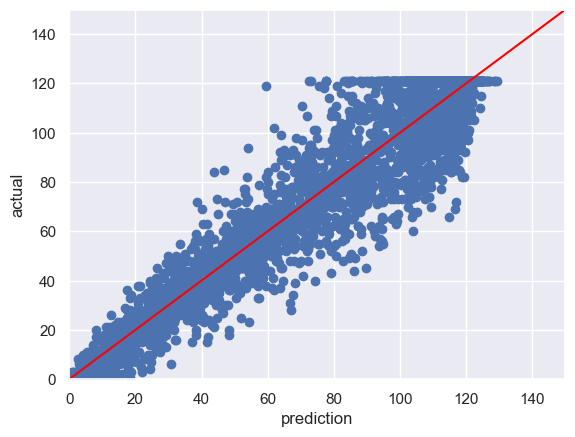

In [ ]:
# validation pred vs. act
plt.figure()
plt.scatter(x=pred_y, y=val_y)
sns.lineplot(x = [0, 150], y = [0, 150], color = "red")
plt.xlabel("prediction")
plt.ylabel("actual")
plt.xlim([0,150])
plt.ylim([0,150])
plt.show()

## Prediction

In [ ]:
# features = [i for i in train_df.columns if i not in ["engine", "cycle_time", "RUL"]]
features = [i for i in train_df.columns if i not in ["engine", "RUL"]]

# store test data
test_df_last = test_df.groupby("engine").last().reset_index()
test_X_std = test_df_last[features]

In [ ]:
# prediction with best model
pred_y = selected_model.predict(test_X_std)

In [ ]:
# test data metrics

test_y = RUL_df["RUL"]
r2, mse, mae = score(test_y, pred_y, "RegModel")

print("r2 score:", r2)
print("mse:", mse)
print("mae:", mae)

r2 score: 0.8476963817238776
mse: 263.00848837103996
mae: 11.822871949713521


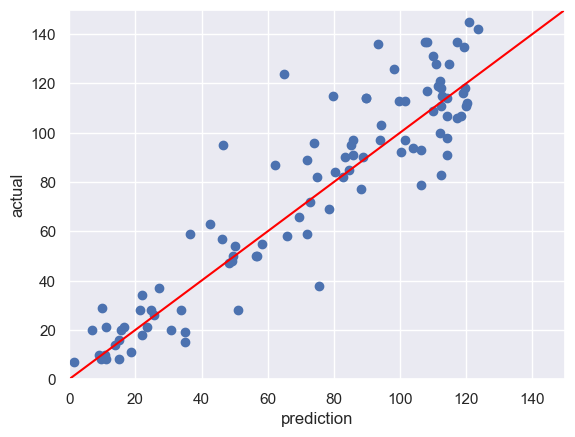

In [ ]:
# test pred vs. act (scatter)
plt.figure()
plt.scatter(x=pred_y, y=test_y)
sns.lineplot(x = [0, 150], y = [0, 150], color = "red")
plt.xlabel("prediction")
plt.ylabel("actual")
plt.xlim([0,150])
plt.ylim([0,150])
plt.show()

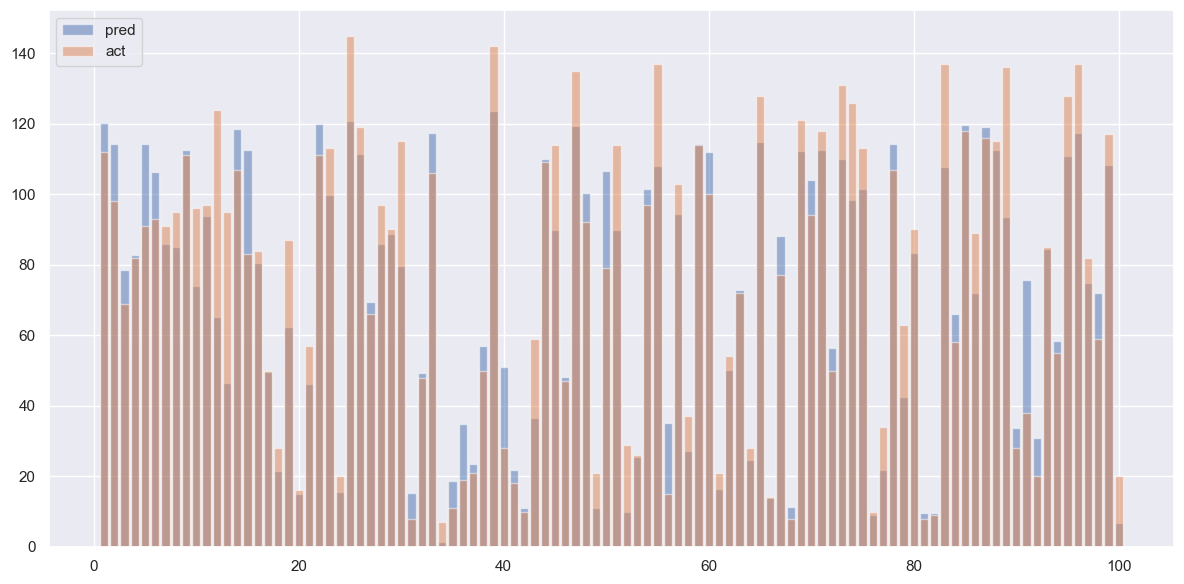

In [ ]:
# test pred vs. act (bar)
plt.figure(figsize=(12,6))
plt.bar(RUL_df["engine"], pred_y, label="pred", alpha=0.5)
plt.bar(RUL_df["engine"], test_y, label="act", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Maintenance limit RUL=42

In [71]:
prediction = pd.DataFrame(pred_y, columns=["prediction"])
prediction["pred_maintenance"] = np.where(prediction["prediction"]<=42, "yes", "no")
actual = pd.DataFrame(test_y, columns=["RUL"])
actual["act_maintenance"] = np.where(actual["RUL"]<=42, "yes", "no")
engine = pd.DataFrame(np.arange(1, 101, 1), columns=["engines"])

result = pd.concat([engine, actual, prediction], axis=1)
result["check"] = np.where(result["act_maintenance"]==result["pred_maintenance"], 1, 0)
print(result.head())

   engines  RUL act_maintenance  prediction pred_maintenance  check
0        1  112              no  120.180466               no      1
1        2   98              no  114.304339               no      1
2        3   69              no   78.528487               no      1
3        4   82              no   82.636358               no      1
4        5   91              no  114.139958               no      1


In [77]:
print(len(result[(result["act_maintenance"]=="yes") & (result["pred_maintenance"]=="yes")]))
print(len(result[(result["act_maintenance"]=="yes") & (result["pred_maintenance"]=="no")]))
print(len(result[(result["act_maintenance"]=="no") & (result["pred_maintenance"]=="yes")]))
print(len(result[(result["act_maintenance"]=="no") & (result["pred_maintenance"]=="no")]))

26
2
1
71
